## 1. Initialization

#### 1.1 Importing libraries

In [1]:
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
import tensorflow_addons as tfa
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import skimage
from skimage.exposure import is_low_contrast
from skimage.transform import rescale, SimilarityTransform, AffineTransform, rotate
# comment for kaggle/colab
##########################
import mediapipe as mp
import Augmentor
from sympy import im
##########################
import tensorflow as tf
# import tensorflow_addons as tfa
# import tensorflow_gan as tfg
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras import layers, losses
from keras.layers import Input, InputLayer,  Dense, Embedding, Conv2D, Dropout, Flatten, RandomTranslation, LeakyReLU, Reshape, Conv2DTranspose, GlobalMaxPooling2D
from keras.models import Sequential, Model
from keras import activations
from tensorflow.keras.applications import DenseNet121, resnet50, MobileNetV2, VGG19, InceptionV3
import tensorflow_hub as hub
import tensorflow_probability as tfp
from PIL import Image, ImageFont, ImageDraw, ImageColor
import os
import pathlib
import tarfile
import pathlib as pb
import pandas as pd
from collections import defaultdict
import enum
import random
import seaborn as sns
from tqdm import tqdm
import datetime
import shutil
# comment for kaggle/colab
from rembg import remove
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, dummy
import warnings
import time 
from IPython.display import FileLinks, FileLink


sns.set_style('dark')
np.random.seed(42)
warnings.filterwarnings('ignore')


#### 1.2 Libraries version check

In [2]:
tf.__version__, tf.executing_eagerly(), np.__version__, pd.__version__


('2.10.0', True, '1.21.6', '1.5.2')

In [3]:
!nvidia-smi

Sun Nov 27 13:17:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.74       Driver Version: 512.74       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   42C    P8     9W /  N/A |   1266MiB /  4096MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### 1.3 Declaring constants

In [4]:
kaggle = False

DATASET_DIRECTORY = '../Dataset/tea sickness dataset/'
if kaggle:
    DATASET_DIRECTORY = '../input/tea-dataset/tea sickness dataset - kaggle'


INCEPTION_TFHUB = 'https://tfhub.dev/tensorflow/tfgan/eval/inception/1'


OBJECT_DETECTION_MODEL_DICT = {'ssd': {'dir': './object_detction_models/mobilenet_ssd',
                                       'name': 'openimages_v4_ssd_mobilenet_v2_1.tar.gz'},

                               'rcnn': {'dir': './object_detction_models/inception_resnet',
                                        'name': 'faster_rcnn_openimages_v4_inception_resnet_v2_1.tar.gz'}
                               }
MODEL_CHECKPOINT_PATHS = {
    'vgg': './checkpoints/vgg/',
     'resnet': './checkpoints/resnet_50/',
    'mobilenet': './checkpoints/mobilenet/',
    'inception': './checkpoints/inception/',
    'densenet': './checkpoints/densenet/',
    'wgan': './checkpoints/wgan/',
    'wgan_res': './checkpoints/wgan_res/',
}


class model_type(enum.Enum):
    mobilenet_ssd = 'ssd'
    inception_resnet_rcnn = 'rcnn'


BATCH_SIZE_DATASET = 16
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_GAN_TRAIN = 4
BUFFER_SIZE = 1000
IMG_SIZE_TRAIN = (180, 180)



## 2. Reading file paths and initial analysis of images

#### 2.1 Display all the tea dataset sickness folders present

In [5]:
sickness_folder_lst = os.listdir(os.path.abspath(DATASET_DIRECTORY))
sickness_folder_lst


['algal leaf',
 'Anthracnose',
 'bird eye spot',
 'brown blight',
 'gray light',
 'healthy',
 'red leaf spot',
 'white spot']

#### 2.2 Display the number of images in each sickness folder

In [6]:
sickness_folder_dict = defaultdict(lambda: 'NA')

for sickenss in sickness_folder_lst:
    folder_path = os.path.join(DATASET_DIRECTORY, sickenss)
    img_path_lst = list(pb.Path(folder_path).glob('*.jpg'))
    img_path_lst = [os.path.abspath(path) for path in img_path_lst]
    sickness_folder_dict.update({sickenss: img_path_lst})

image_count_df = pd.DataFrame(index=sickness_folder_dict.keys(), data=[len(
    v) for v in sickness_folder_dict.values()], columns=['image_count'])
image_count_df.to_clipboard()


#### 2.3 Data visualization

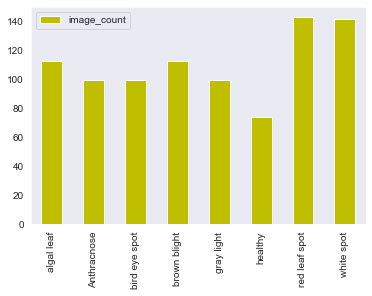

In [7]:
image_count_df.plot.bar(color='y')
plt.show()


In [8]:
def axis_plot(ax, _img_path, desc, fontsize=12):
    """_summary_

    Args:
        ax (_type_): _description_
        _img_path (_type_): _description_
        desc (_type_): _description_
        fontsize (int, optional): _description_. Defaults to 12.
    """
    img_array = cv2.imread(str(_img_path))

    ax.imshow(img_array)
    ax.tick_params(left=False, right=False, labelleft=False,
                   labelbottom=False, bottom=False)

    ax.locator_params(nbins=5)

    ax.set_title(desc, fontsize=fontsize)


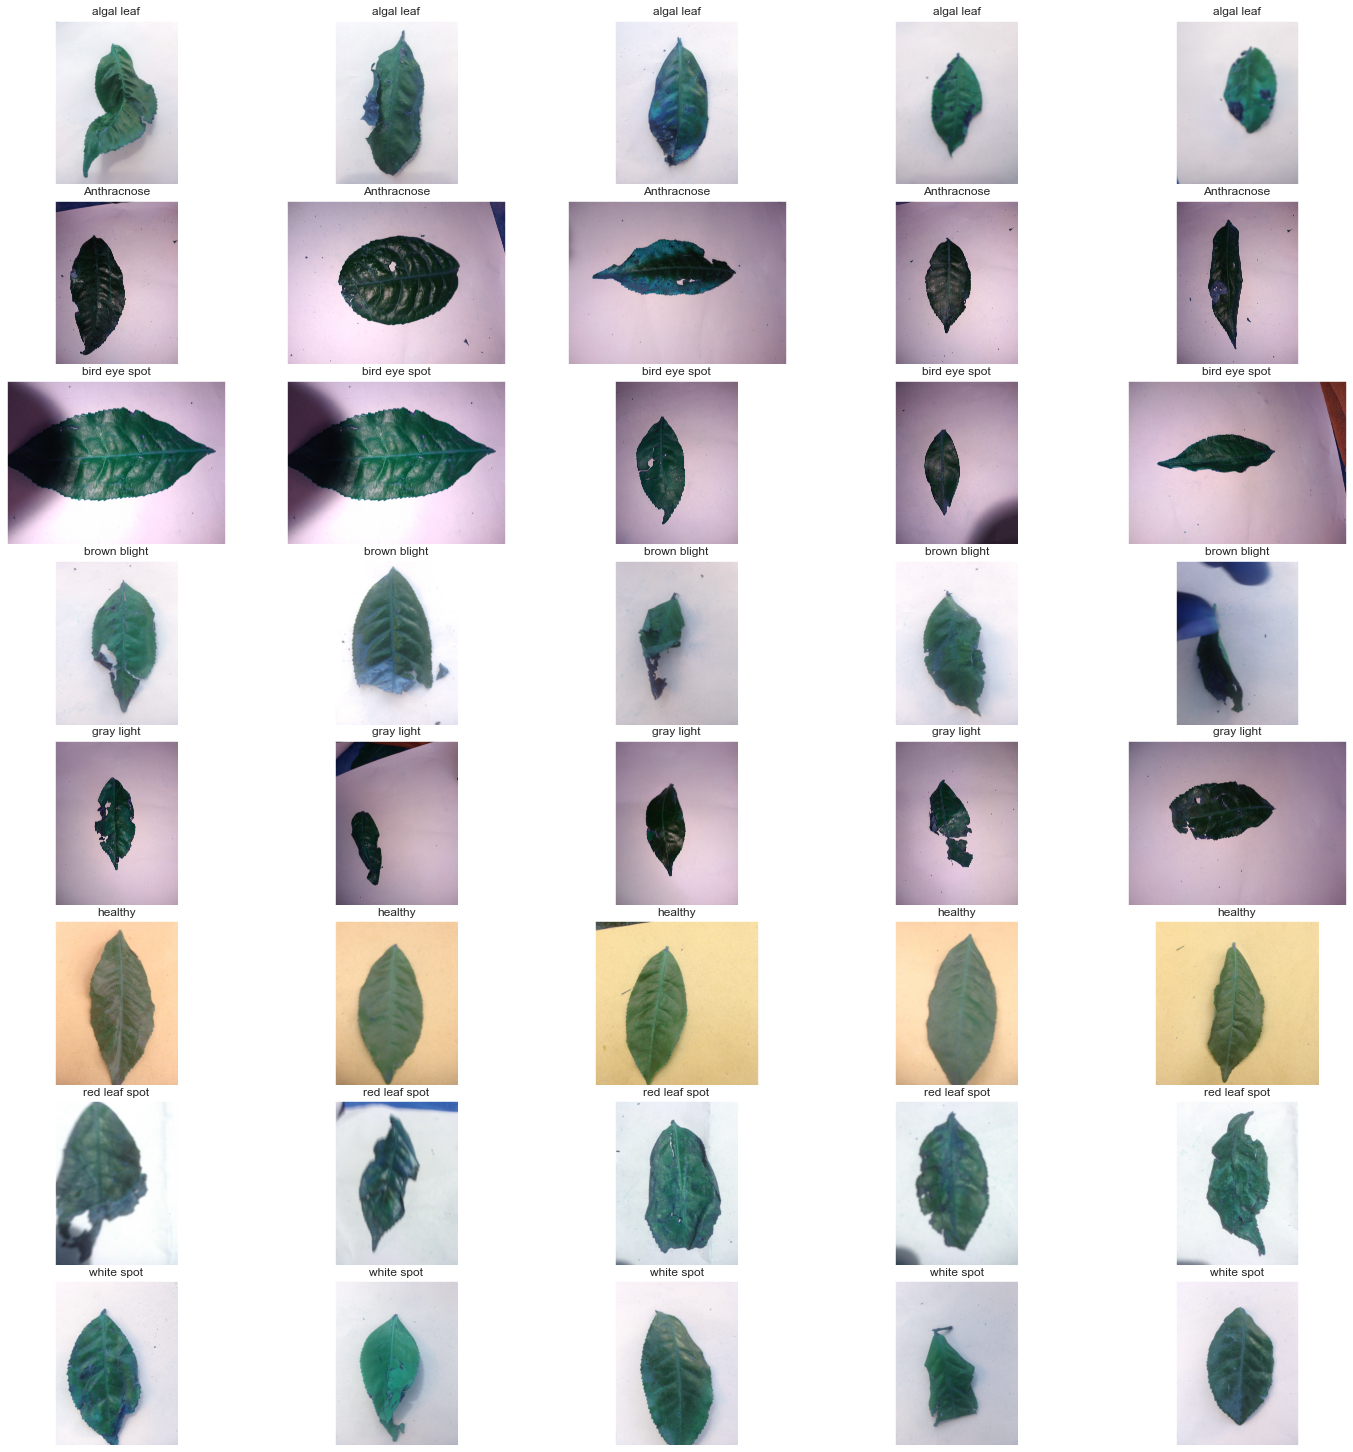

In [9]:
fig, ax = plt.subplots(nrows=8, ncols=5, figsize=(20, 20))

for idx, key_vals in enumerate(sickness_folder_dict.items()):
    key, vals = key_vals
    rand_idxs = np.random.choice(range(len(vals)), size=5)
    vals = [vals[i] for i in rand_idxs]
    for i_dx, val in enumerate(vals):

        axis_plot(ax[idx][i_dx], val, desc=key)

plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.25)


# 3. Image pre-processing pipeline

In [10]:
class HelperFunctions():

    def __init__(self) -> None:
        pass

    def read_single_image(self,  _img_path='', sickness_name='', randomly=False):
        if randomly:
            _img_path = os.path.abspath(np.random.choice(
                sickness_folder_dict[sickness_name]))

        else:
            _img_path = os.path.abspath(_img_path)

        return _img_path, cv2.imread(str(_img_path))

    def resize_image(self, img_array,  new_dsize):
        img_array = cv2.resize(img_array, dsize=new_dsize)
        return img_array

    def display_image(self, img_array, desc='', fontsize=14, figsize=(7, 7)):
        """
        Displays an image inside the notebook.
        This is used by download_and_resize_image()
        """
        fig = plt.figure(figsize=figsize)
        plt.grid(False)
        plt.tick_params(left=False, right=False, labelleft=False,
                        labelbottom=False, bottom=False)

        plt.title(desc, fontsize=fontsize)
        plt.imshow(img_array)

    def add_denoising_nlmeans(self, img_array):
        return cv2.fastNlMeansDenoisingColored(img_array, None, 10, 10, 7, 15)

    def add_gaussian_blur(self, img_array):

        return cv2.GaussianBlur(img_array, (5, 5), 0)

    # def add_edge_detection(img_array):
    #     return cv2.Canny(img_array, 30, 150)

    def create_white_bg(self, shape, bg_fp='./white_bg.jpg'):
        white_bg = np.full(shape, 255, dtype=np.uint8)
        plt.imsave(bg_fp, white_bg)

    def superimpose_white_bg(self, img, bg_fp='./white_bg.jpg', binary_mask_th=0.8):
        change_background_mp = mp.solutions.selfie_segmentation

        change_bg_segment = change_background_mp.SelfieSegmentation()
        result = change_bg_segment.process(image=img)
        binary_mask = result.segmentation_mask > binary_mask_th
        binary_mask_3 = np.dstack((binary_mask, binary_mask, binary_mask))

        output_image = np.where(binary_mask_3, img, 255)
        bg_img = cv2.imread(bg_fp)
        output_image = np.where(binary_mask_3, img, bg_img)
        return output_image

    def remove_bg(self, image):
        # Fill the black background with white color
        # rgb to hsv color space
        hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        s_ch = hsv_img[:, :, 1]  # Get the saturation channel

        # Apply threshold - pixels above 5 are going to be 255, other are zeros.
        thesh = cv2.threshold(s_ch, 5, 255, cv2.THRESH_BINARY)[1]
        # Apply opening morphological operation for removing artifacts.
        thesh = cv2.morphologyEx(
            thesh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))

        # Fill the background in thesh with the value 128 (pixel in the foreground stays 0.
        cv2.floodFill(thesh, None, seedPoint=(0, 0),
                      newVal=255, loDiff=1, upDiff=1)

        # Set all the pixels where thesh=128 to red.
        image[thesh == 128] = (255, 255, 255)

        return image

    def remove_bg2(self, image):
        return remove(image)

    def draw_bounding_box_on_image(self,
                                   image,
                                   ymin,
                                   xmin,
                                   ymax,
                                   xmax,
                                   font,
                                   color='#FFFFFF',
                                   thickness=1,
                                   display_str_list=()):
        """
        Adds a bounding box to an image.

        Args:
            image -- the image object
            ymin -- bounding box coordinate
            xmin -- bounding box coordinate
            ymax -- bounding box coordinate
            xmax -- bounding box coordinate
            color -- color for the bounding box edges
            font -- font for class label
            thickness -- edge thickness of the bounding box
            display_str_list -- class labels for each object detected


        Returns:
            No return.  The function modifies the `image` argument 
                        that gets passed into this function

        """
        draw = ImageDraw.Draw(image)
        im_width, im_height = image.size

        # scale the bounding box coordinates to the height and width of the image
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)

        # define the four edges of the detection box
        draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
                   (left, top)],
                  width=thickness,
                  fill=color)

    def draw_boxes(self, image, boxes, class_names, scores):
        """
        Overlay labeled boxes on an image with formatted scores and label names.

        Args:
            image -- the image as a numpy array
            boxes -- list of detection boxes
            class_names -- list of classes for each detected object
            scores -- numbers showing the model's confidence in detecting that object
            max_boxes -- maximum detection boxes to overlay on the image (default is 10)
            min_score -- minimum score required to display a bounding box

        Returns:
            image -- the image after detection boxes and classes are overlaid on the original image.
        """
        # colors = list(ImageColor.colormap.values())

        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                                      25)
        except IOError:
            #print("Font not found, using default font.")
            font = ImageFont.load_default()

            # only display detection boxes that have the minimum score or higher
        idx = np.argmax(scores)

        ymin, xmin, ymax, xmax = tuple(boxes[idx])

        # "{}: {}%".format(class_names[i].decode("ascii"),int(100 * scores[i]))
        display_str = f'Predicted class - {class_names[idx]}'

        # color = colors[hash(class_names[idx]) % len(colors)]
        image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

        # draw one bounding box and overlay the class labels onto the image
        self.draw_bounding_box_on_image(image_pil,
                                        ymin,
                                        xmin,
                                        ymax,
                                        xmax,
                                        # color,
                                        font,
                                        display_str_list=[display_str])
        np.copyto(image, np.array(image_pil))

        return image

    def make_border(self, img_array, border_percent=0.03, display_shape=False):
        border_type = cv2.BORDER_CONSTANT
        img_shape = img_array.shape[:2]
        # Initialize arguments for the filter
        top = int(border_percent * img_array.shape[0])  # shape[0] = rows
        bottom = top
        left = int(border_percent * img_array.shape[1])  # shape[1] = cols
        right = left

        img_array = cv2.copyMakeBorder(
            img_array, top, bottom, left, right, border_type, None, value=(255, 255, 255))
        if display_shape:
            print(img_shape)
        img_array = cv2.resize(src=img_array, dsize=img_shape)

        return img_array

    def sharpen_image(self, img_array, sharpening_kernel):
        # sharpening_kernel = np.array([[0, -1, 0],
        #                       [-1, 5, -1],
        #                       [0, -1, 0]])

        img_array = cv2.filter2D(
            src=img_array, ddepth=-1, kernel=sharpening_kernel)
        return img_array

    def increase_brightness_contrast(self, img_array):
        alpha = 1.1  # Simple contrast control
        beta = 1.2    # Simple brightness control
        final_image = np.zeros(img_array.shape, img_array.dtype)
        for y in range(img_array.shape[0]):
            for x in range(img_array.shape[1]):
                for ch in range(img_array.shape[2]):
                    final_image[y, x, ch] = np.clip(
                        alpha*img_array[y, x, ch] + beta, 0, 255)

        return final_image


In [11]:
class LocalizeObjects(HelperFunctions):
    def __init__(self, img_dsize=IMG_SIZE_TRAIN) -> None:

        self._img_dsize = img_dsize
        self.__model_ref = None
        self._buffer_img_array = None
        super().__init__()

    def extract_model(self, file_path, dir):
        model_file = tarfile.open(file_path)
        model_file.extractall(dir)
        model_file.close()

    def load_model(self, model_type):
        if isinstance(model_type, enum.Enum):
            model_type = model_type.value

        if model_type in OBJECT_DETECTION_MODEL_DICT:

            model_dir = OBJECT_DETECTION_MODEL_DICT[model_type]['dir']
            model_name = OBJECT_DETECTION_MODEL_DICT[model_type]['name']
            file_path = os.path.join(model_dir, model_name)

            if not pathlib.Path(f'{model_dir}/saved_model.pb').exists():
                self.extract_model(file_path, model_dir)

            self._model_ref = hub.load(model_dir)
            self._model_ref = self._model_ref.signatures['default']
            print(f'Model loaded from -> {model_dir}')
        else:
            raise Exception(
                f'{model_type} is not mapped to any object detection model')

    def read_resize_image(self, image_path, display=False):
        try:
            # image_path = str(os.path.abspath(image_path))
            _, _img_array = self.read_single_image(_img_path=image_path)
            _size_1 = _img_array.shape
            _img_array = self.resize_image(
                _img_array, new_dsize=self._img_dsize)
            self._buffer_img_array = _img_array

            if display:
                print(f'Old size - {_size_1}, New size - {_img_array.shape}')
                self.display_image(img_array=_img_array, desc=f'Resized image')

        except Exception as exp:
            print(exp)

    def predict_bbox(self):
        _converted_img = tf.image.convert_image_dtype(
            self._buffer_img_array, tf.float32)[tf.newaxis, ...]
        result = self._model_ref(_converted_img)
        result = {key: value.numpy() for key, value in result.items()}
        #image_with_boxes = self.draw_boxes(img_array.numpy(), result["detection_boxes"],result["detection_class_entities"], result["detection_scores"])
        return result

    def draw_predicted_bbox(self, result_dict, is_diplay=False):
        img_box = self.draw_boxes(self._buffer_img_array,
                                  result_dict["detection_boxes"],
                                  result_dict["detection_class_entities"],
                                  result_dict["detection_scores"])
        if is_diplay:
            self.display_image(img_box)

        return img_box

    def get_object_dimensions(self, img_size, result_dict):
        boxes = result_dict["detection_boxes"]
        scores = result_dict["detection_scores"]
        box = boxes[np.argmax(scores)]

        ymin, xmin, ymax, xmax = tuple(box)
        # idx = np.argmax(scores)
        im_width, im_height = self._img_dsize

        # scale the bounding box coordinates to the height and width of the image
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)

        return (left, right, top, bottom)


In [12]:
## Create class objects for image pre-processing ##

lo = LocalizeObjects()
hf = HelperFunctions()


In [13]:

lo.load_model(model_type=model_type.inception_resnet_rcnn)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model loaded from -> ./object_detction_models/inception_resnet


### Experiments with pre-processing pipeline

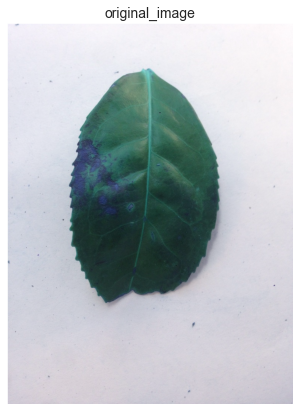

In [14]:
exp_path, orig_image = hf.read_single_image(
    sickness_name='algal leaf', randomly=True)

hf.display_image(orig_image, desc='original_image')


g:\Learning\Degree Courses\MS AI ML\Research\Tea Sickeness Project\Dataset\tea sickness dataset\algal leaf\UNADJUSTEDNONRAW_thumb_53.jpg
Old size - (1024, 768, 3), New size - (180, 180, 3)


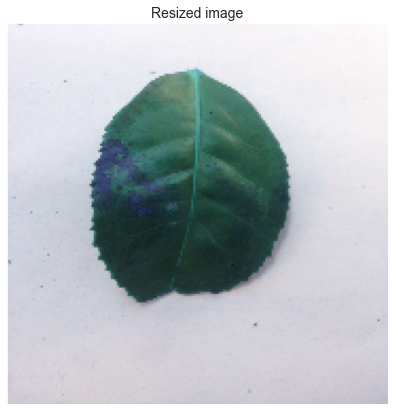

In [15]:
print(exp_path)
lo.read_resize_image(str(exp_path), display=True)


In [16]:
res_dict = lo.predict_bbox()


In [27]:
res_dict['detection_class_entities'][np.argmax(res_dict['detection_scores'])]


b'Marine invertebrates'

CPU times: total: 0 ns
Wall time: 0 ns


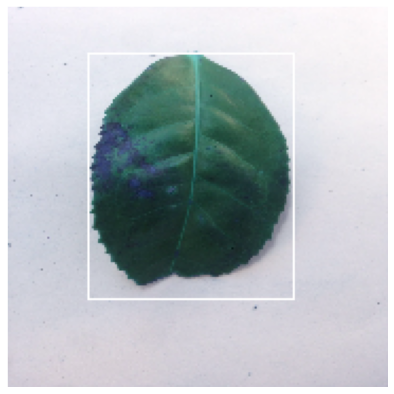

In [28]:
%time
pred_bbox_img = lo.draw_predicted_bbox(res_dict, is_diplay=True)


In [29]:
left, right, top, bottom = tuple(round(v)
                                 for v in lo.get_object_dimensions(0, res_dict))
left, right, top, bottom


(38, 136, 23, 139)

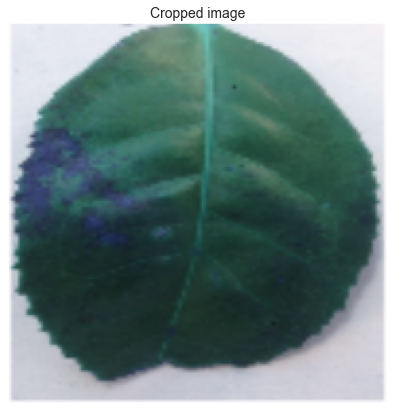

In [30]:
pred_bbox_img_cropped = pred_bbox_img[top:bottom, left:right]
pred_bbox_img_cropped = hf.resize_image(
    pred_bbox_img_cropped, new_dsize=IMG_SIZE_TRAIN)
hf.display_image(pred_bbox_img_cropped, desc='Cropped image')


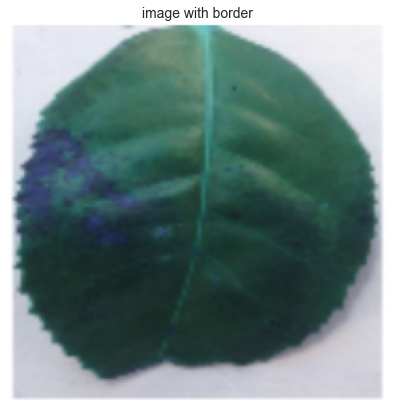

In [31]:
pred_bbox_img_cropped_border = hf.make_border(
    pred_bbox_img_cropped, border_percent=0.01)
hf.display_image(pred_bbox_img_cropped_border, desc='image with border')


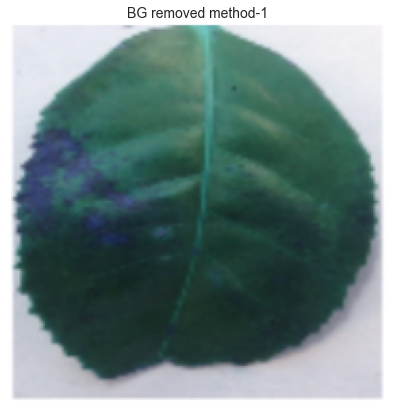

In [32]:
pred_bbox_img_cropped_border_rembg_1 = hf.remove_bg(
    pred_bbox_img_cropped_border)
hf.display_image(pred_bbox_img_cropped_border_rembg_1,
                 desc='BG removed method-1')


CPU times: total: 0 ns
Wall time: 0 ns


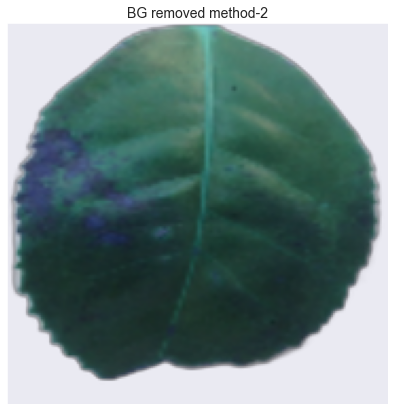

In [33]:
%time

pred_bbox_img_cropped_border_rembg_2 = hf.remove_bg2(
    pred_bbox_img_cropped_border)
hf.display_image(pred_bbox_img_cropped_border_rembg_2,
                 desc='BG removed method-2')


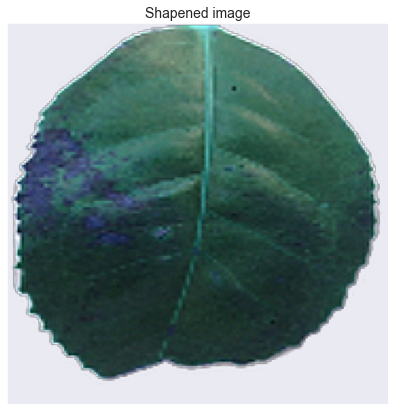

In [34]:
sharpening_kernel = np.array([[0, -1, 0],
                              [-1, 5, -1],
                              [0, -1, 0]])

image_sharp = hf.sharpen_image(
    pred_bbox_img_cropped_border_rembg_2, sharpening_kernel)
hf.display_image(image_sharp, desc='Shapened image')


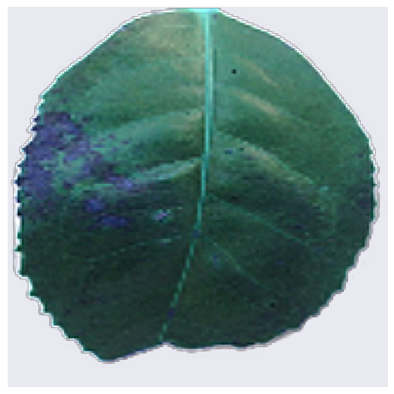

In [35]:
final_image = hf.increase_brightness_contrast(image_sharp)
hf.display_image(final_image)


In [26]:
def plot_image(ax, img_array, desc, fontsize=14):
    ax.imshow(img_array)
    ax.tick_params(left=False, right=False, labelleft=False,
                   labelbottom=False, bottom=False)
    ax.set_title(desc, fontsize=fontsize)
    # ax.locator_params(nbins=4)


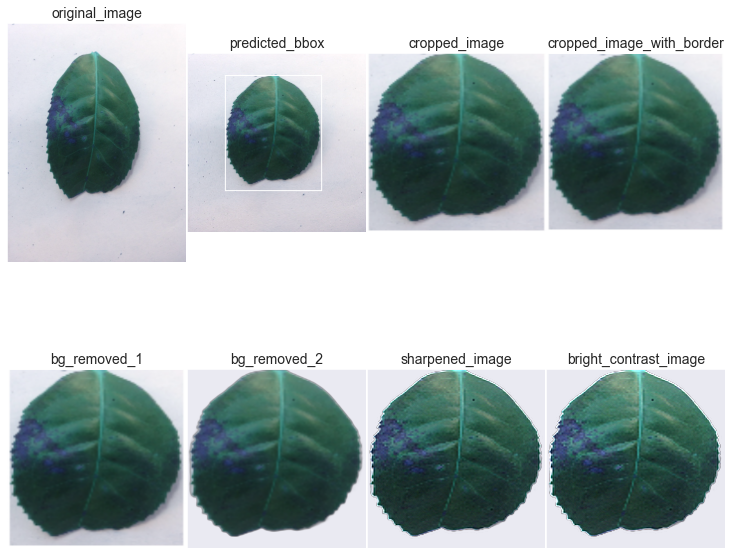

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=[10, 10])

plot_image(ax[0][0], orig_image, desc='original_image')
plot_image(ax[0][1], pred_bbox_img, desc='predicted_bbox')
plot_image(ax[0][2], pred_bbox_img_cropped, desc='cropped_image')
plot_image(ax[0][3], pred_bbox_img_cropped_border,
           desc='cropped_image_with_border')
plot_image(ax[1][0], pred_bbox_img_cropped_border_rembg_1,
           desc='bg_removed_1')
plot_image(ax[1][1], pred_bbox_img_cropped_border_rembg_2,
           desc='bg_removed_2')


plot_image(ax[1][2], image_sharp, desc='sharpened_image')
plot_image(ax[1][3], final_image, desc='bright_contrast_image')
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.25)


### Pre-processing pipeline run automated

In [28]:
# %time
# hf = HelperFunctions()
# lo = LocalizeObjects()
# lo.load_model(model_type=model_type.inception_resnet_rcnn)
# sharpening_kernel = np.array([[0, -1, 0],
#                               [-1, 5, -1],
#                               [0, -1, 0]])


In [29]:
######################
##### Legacy code ####
######################


# for disease, path_lst in sickness_folder_dict.items():

#     tmp_path = path_lst[0]
#     tmp_dir = os.path.abspath(os.path.dirname(tmp_path))
#     processed_dir = os.path.join(tmp_dir, 'processed')
#     if not os.path.exists(processed_dir):
#         os.mkdir(processed_dir)
#     else:
#         shutil.rmtree(processed_dir)
#         os.mkdir(processed_dir)

#     dt_lst = []
#     for path in tqdm(path_lst, desc=f'Pre-processing images of {disease}...'):

#         t1 = datetime.datetime.now()
#         file_name = os.path.basename(path)

#         lo.read_resize_image(path)
#         res_dict = lo.predict_bbox()
#         pred_bbox_img = lo.draw_predicted_bbox(res_dict, is_diplay=False)

#         _top, _bottom, _left, _right = tuple(
#             round(v) for v in lo.get_object_dimensions(0, res_dict))
#         # _top, _bottom, _left, _right = _top-1, _bottom+1, _left-1, _right+1

#         pred_bbox_img_cropped = pred_bbox_img[_left:_right, _top:_bottom]

#         pred_bbox_img_cropped = hf.resize_image(
#             pred_bbox_img_cropped, new_dsize=IMG_SIZE_TRAIN)

#         pred_bbox_img_cropped_border = hf.make_border(
#             pred_bbox_img_cropped, border_percent=0.01)

#         pred_bbox_img_cropped_border_rembg_2 = hf.remove_bg2(
#             pred_bbox_img_cropped_border)

#         image_sharp = hf.sharpen_image(
#             pred_bbox_img_cropped_border_rembg_2, sharpening_kernel)

#         final_image = hf.increase_brightness_contrast(image_sharp)

#         file_path = os.path.join(processed_dir, file_name)
#         cv2.imwrite(file_path, final_image)

#         dt = datetime.datetime.now() - t1
#         dt_lst.append(dt.seconds+(dt.microseconds*10e-6))

#     print(
#         f'INFO: Average processing time for each image of {disease} is {sum(dt_lst)/len(dt_lst)} seconds')


In [30]:

def run_image_preprocessing():
    hf = HelperFunctions()
    lo = LocalizeObjects()
    lo.load_model(model_type=model_type.inception_resnet_rcnn)
    sharpening_kernel = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])

    for disease, path_lst in sickness_folder_dict.items():

        tmp_path = path_lst[0]
        tmp_dir = os.path.abspath(os.path.dirname(tmp_path))
        processed_dir = os.path.join(tmp_dir, 'processed')
        if not os.path.exists(processed_dir):
            os.mkdir(processed_dir)
        else:
            shutil.rmtree(processed_dir)
            os.mkdir(processed_dir)

        dt_lst = []
        for path in tqdm(path_lst, desc=f'Pre-processing images of {disease}...'):

            t1 = datetime.datetime.now()
            file_name = os.path.basename(path)

            lo.read_resize_image(path)
            res_dict = lo.predict_bbox()
            pred_bbox_img = lo.draw_predicted_bbox(res_dict, is_diplay=False)

            _top, _bottom, _left, _right = tuple(
                round(v) for v in lo.get_object_dimensions(0, res_dict))
            # _top, _bottom, _left, _right = _top-1, _bottom+1, _left-1, _right+1

            pred_bbox_img_cropped = pred_bbox_img[_left:_right, _top:_bottom]

            pred_bbox_img_cropped = hf.resize_image(
                pred_bbox_img_cropped, new_dsize=IMG_SIZE_TRAIN)

            pred_bbox_img_cropped_border = hf.make_border(
                pred_bbox_img_cropped, border_percent=0.01)

            pred_bbox_img_cropped_border_rembg_2 = hf.remove_bg2(
                pred_bbox_img_cropped_border)

            image_sharp = hf.sharpen_image(
                pred_bbox_img_cropped_border_rembg_2, sharpening_kernel)

            final_image = hf.increase_brightness_contrast(image_sharp)

            file_path = os.path.join(processed_dir, file_name)
            cv2.imwrite(file_path, final_image)

            dt = datetime.datetime.now() - t1
            dt_lst.append(dt.seconds+(dt.microseconds*10e-6))

        print(
            f'INFO: Average processing time for each image of {disease} is {sum(dt_lst)/len(dt_lst)} seconds')


In [31]:
%time
run_image_preprocessing()


# 4. Preprocessed Dataset loading pipeline

### 4.1 Load the preprocessed data

In [8]:
def get_preprocessed_fp_dict(old_sickness_folder_dict):
    sickness_folder_processed_dict = defaultdict()
    for key, values in old_sickness_folder_dict.items():
        dir_name = os.path.dirname(values[0])
        new_path_lst = []
        for val in values:

            new_path = os.path.join(
                dir_name, 'processed', os.path.basename(val))
            new_path_lst.append(pb.Path(new_path))

        sickness_folder_processed_dict.update({key: new_path_lst})

    return sickness_folder_processed_dict


In [9]:
sickness_folder_processed_dict = get_preprocessed_fp_dict(sickness_folder_dict)


### 4.2 Split the image data paths into training and testing 

In [10]:

def get_train_test_fp_list(processed_sickness_folder_dict, train_split_ratio=0.8, test_split_ratio=0.2):
    train_img_path_lst = []
    test_img_path_lst = []

    for _, values in sickness_folder_processed_dict.items():
        number_of_images = len(values)
        values_lst = list(values)
        number_of_train_images = int(
            np.ceil(number_of_images*train_split_ratio))
        number_of_test_images = int(
            np.floor(number_of_images*test_split_ratio))

        train_image_paths = np.random.choice(
            values_lst, number_of_train_images)
        test_image_paths = np.random.choice(values_lst, number_of_test_images)

        train_img_path_lst.extend(train_image_paths)
        test_img_path_lst.extend(test_image_paths)

    return (train_img_path_lst, test_img_path_lst)


In [11]:
train_img_path_lst, test_img_path_lst = get_train_test_fp_list(
    sickness_folder_processed_dict)

print(
    f'Train images # -> {len(train_img_path_lst)}\nTest images # -> {len(test_img_path_lst)}')


Train images # -> 711
Test images # -> 174


In [12]:
# ### TEST ###
# a = np.array(range(10), dtype=np.float32).reshape(-1,1)
# b = np.array(range(10), dtype=np.uint8).reshape(-1,1)

# tf.concat([a,b], axis = 1)


In [13]:
def get_img_path_and_labels_df(img_path_lst, parents_idx=1)->pd.DataFrame:
    """Generate a pandas dataframe having the image paths, disease and OHE vectors as columns"""
    df = pd.DataFrame(img_path_lst, columns=['paths'])
    df['paths'] = df['paths'].apply(lambda x: str(os.path.abspath(x)))

    df['disease'] = df['paths'].apply(
        lambda x: os.path.basename(list(pb.Path(x).parents)[parents_idx]))

    disease_df = pd.get_dummies(df['disease'])  # , dtype = np.float16)
    df = pd.concat([df, disease_df], axis=1)
    df.columns = df.columns.str.lower()
    df['disease'] = df['disease'].str.lower()
    return df


In [14]:
train_data_df = get_img_path_and_labels_df(train_img_path_lst, parents_idx=1)
train_data_df.to_clipboard()


In [15]:
train_data_df['disease'].unique()


array(['algal leaf', 'anthracnose', 'bird eye spot', 'brown blight',
       'gray light', 'healthy', 'red leaf spot', 'white spot'],
      dtype=object)

In [16]:
actual_data_df = train_data_df.copy()



<br>
<br>
<br>
<br>

### 4.3 Geometrical Augmentation



In [19]:
def geometrical_augmentation(tmp_src_aug_dir, dst_aug_dir, number_of_image_to_augment):
    p = Augmentor.Pipeline(tmp_src_aug_dir, output_directory=dst_aug_dir)

    p.flip_random(probability=0.5)

    # Add a shear operation to the pipeline
    p.shear(probability=0.2, max_shear_left=0.3, max_shear_right=0.3)

    # Add a rotate operation to the pipeline:
    p.rotate_random_90(probability=0.5)

    p.skew_corner(probability=0.3)

    # We are adding such that total # of  samples per class is same i.e. 1000, to make sure that none
    p.sample(number_of_image_to_augment)


In [42]:
def handle_augmentation(train_data_df, augment_split_ratio=0.6):
    aug_count = 0
    for disease in tqdm(train_data_df['disease'].unique(), desc='Augmenting images...'):
        df_path_disease_lst = train_data_df[train_data_df['disease']
                                            == disease]['paths'].values.tolist()
        number_of_image_to_augment = int(
            np.floor(len(df_path_disease_lst)*augment_split_ratio))
        print(
            f'For {disease}, number of images to augment is {number_of_image_to_augment}')

        # processed dir path of a sickness folder
        dir_path = os.path.dirname(df_path_disease_lst[0])

        # temporary augmentation directory for storing buffer data
        tmp_src_aug_dir = os.path.join(dir_path, 'tmp_aug')
        if os.path.exists(tmp_src_aug_dir):
            shutil.rmtree(tmp_src_aug_dir)
        else:
            os.mkdir(tmp_src_aug_dir)

        # copying the train images of a disease into the temporary directory
        for img_path in df_path_disease_lst:
            tmp_path = os.path.join(
                tmp_src_aug_dir, os.path.basename(img_path))
            shutil.copy(img_path, tmp_path)

        # augmentation destination directory
        dst_aug_dir = os.path.join(dir_path, 'output')

        # deleting the previous augmentation data from the destibnation folder
        if os.path.exists(dst_aug_dir):
            shutil.rmtree(dst_aug_dir)

        geometrical_augmentation(
            tmp_src_aug_dir, dst_aug_dir, number_of_image_to_augment)

        # deleting the temporary augmentation source directory after usage
        if os.path.exists(tmp_src_aug_dir):
            shutil.rmtree(tmp_src_aug_dir)

        aug_count += number_of_image_to_augment

    print(f'Number of images augmented is {aug_count}')


In [43]:
## Run the image augmentation

handle_augmentation(train_data_df)


### 4.4 Load the baseline model dataset

#### 4.4.1 Load all the augmented image paths

In [17]:
def get_augmented_image_list(train_data_df):
    tmp_train_data_df = train_data_df.copy()
    aug_img_list_all_disease = []
    for disease in train_data_df['disease'].unique():
        tmp_df = pd.DataFrame()
        df_path_disease_lst = train_data_df[train_data_df['disease']
                                            == disease]['paths'].values.tolist()
        dir_path = os.path.dirname(df_path_disease_lst[0])
        # print(dir_path)
        aug_dir_path = os.path.join(dir_path, 'output')
        aug_img_list = list(pb.Path(aug_dir_path).glob('*.jpg'))

        if len(aug_img_list) > 0:
            aug_img_list_all_disease.extend(aug_img_list)
        else:
            raise Exception(
                f'No augmentation output folder found in {os.path.dirname(aug_dir_path)}')
    return aug_img_list_all_disease


In [18]:
aug_img_list_all_disease = get_augmented_image_list(train_data_df)
len(aug_img_list_all_disease)


425

In [19]:
augmented_df = get_img_path_and_labels_df(
    aug_img_list_all_disease, parents_idx=2)
augmented_df


paths     disease  \
0    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
1    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
2    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
3    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
4    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
..                                                 ...         ...   
420  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
421  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
422  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
423  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
424  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   

     anthracnose  algal leaf  bird eye spot  brown blight  gray light  \
0              0           1              0             0           0   
1              0           1              0             0           0   
2              0           1              0             0           0   
3              0           1              0             0           0   
4              0           1              0             0           0   
..           ...         ...            ...           ...         ...   
420            0           0              0             0           0   
421            0           0              0             0           0   
422            0           0              0             0           0   
423            0           0              0             0           0   
424            0           0              0             0           0   

     healthy  red leaf spot  white spot  
0          0              0           0  
1          0              0           0  
2          0              0           0  
3          0              0           0  
4          0              0           0  
..       ...            ...         ...  
420        0              0           1  
421        0              0           1  
422        0              0           1  
423        0              0           1  
424        0              0           1  

[425 rows x 10 columns]

#### 4.4.2 Concatenate the real and geometrically augmented image paths

In [20]:
print(f'Before augmentation - {train_data_df.shape}')
train_data_df = pd.concat([train_data_df, augmented_df], axis=0)
print(f'After augmentation - {train_data_df.shape}')


Before augmentation - (711, 10)
After augmentation - (1136, 10)


In [21]:
train_data_df


paths     disease  \
0    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
1    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
2    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
3    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
4    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
..                                                 ...         ...   
420  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
421  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
422  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
423  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
424  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   

     anthracnose  algal leaf  bird eye spot  brown blight  gray light  \
0              0           1              0             0           0   
1              0           1              0             0           0   
2              0           1              0             0           0   
3              0           1              0             0           0   
4              0           1              0             0           0   
..           ...         ...            ...           ...         ...   
420            0           0              0             0           0   
421            0           0              0             0           0   
422            0           0              0             0           0   
423            0           0              0             0           0   
424            0           0              0             0           0   

     healthy  red leaf spot  white spot  
0          0              0           0  
1          0              0           0  
2          0              0           0  
3          0              0           0  
4          0              0           0  
..       ...            ...         ...  
420        0              0           1  
421        0              0           1  
422        0              0           1  
423        0              0           1  
424        0              0           1  

[1136 rows x 10 columns]

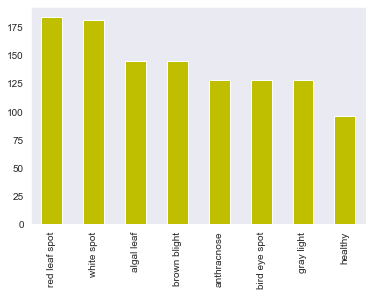

In [22]:
train_data_df.disease.value_counts().plot.bar(color='y')
plt.show()


#### 4.4.3 Getting X-image paths and y-label one-hot encoded vectors

In [23]:
paths_X_train = train_data_df['paths'].values.tolist()

[paths_X_train[i] for i in np.random.randint(
    low=0, high=len(paths_X_train)-1, size=5)]


['g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\white spot\\processed\\UNADJUSTEDNONRAW_thumb_8b.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\brown blight\\processed\\UNADJUSTEDNONRAW_thumb_141.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\brown blight\\processed\\output\\tmp_aug_original_UNADJUSTEDNONRAW_thumb_11a.jpg_0e69c008-1eee-4ed5-a87c-cd75c7405122.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\white spot\\processed\\UNADJUSTEDNONRAW_thumb_d1.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\brown blight\\processed\\UNADJUSTEDNONRAW_thumb_124.jpg']

In [24]:
lables_y_train = train_data_df[train_data_df['disease'].unique()].values

[lables_y_train[i] for i in np.random.randint(
    low=0, high=len(lables_y_train)-1, size=5)]


[array([0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8),
 array([0, 0, 1, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8),
 array([0, 0, 1, 0, 0, 0, 0, 0], dtype=uint8)]

In [25]:
test_data_df = get_img_path_and_labels_df(test_img_path_lst, parents_idx=1)
test_data_df


paths     disease  \
0    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
1    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
2    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
3    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
4    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
..                                                 ...         ...   
169  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
170  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
171  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
172  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
173  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   

     anthracnose  algal leaf  bird eye spot  brown blight  gray light  \
0              0           1              0             0           0   
1              0           1              0             0           0   
2              0           1              0             0           0   
3              0           1              0             0           0   
4              0           1              0             0           0   
..           ...         ...            ...           ...         ...   
169            0           0              0             0           0   
170            0           0              0             0           0   
171            0           0              0             0           0   
172            0           0              0             0           0   
173            0           0              0             0           0   

     healthy  red leaf spot  white spot  
0          0              0           0  
1          0              0           0  
2          0              0           0  
3          0              0           0  
4          0              0           0  
..       ...            ...         ...  
169        0              0           1  
170        0              0           1  
171        0              0           1  
172        0              0           1  
173        0              0           1  

[174 rows x 10 columns]

In [26]:
paths_X_test = test_data_df['paths'].values.tolist()


[paths_X_test[i] for i in np.random.randint(
    low=0, high=len(paths_X_test)-1, size=5)]


['g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\red leaf spot\\processed\\UNADJUSTEDNONRAW_thumb_1f7.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\red leaf spot\\processed\\UNADJUSTEDNONRAW_thumb_1cc.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\Anthracnose\\processed\\IMG_20220503_145942.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\Anthracnose\\processed\\IMG_20220503_145318.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\Anthracnose\\processed\\IMG_20220503_143831.jpg']

In [27]:
lables_y_test = test_data_df[test_data_df['disease'].unique()].values

[lables_y_test[i] for i in np.random.randint(
    low=0, high=len(lables_y_test)-1, size=5)]


[array([0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8),
 array([1, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8),
 array([1, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)]

#### 4.4.4 Splitting the test set into test set and validation set

In [28]:
print(len(paths_X_test))


174


In [29]:
paths_X_test, paths_X_val, lables_y_test, lables_y_val = train_test_split(
    paths_X_test, lables_y_test, train_size=0.6, test_size=0.4, random_state=42)


In [30]:
len(paths_X_test), lables_y_val.shape


(104, (70, 8))

### 4.5 Image dataset streamimg

In [31]:
def map_func(image_path, lables):
    """ This function will take the image_path & caption and return it's feature & respective caption. """

    img_tensor = skimage.io.imread(image_path.decode('utf-8'))
    img_tensor = img_tensor.astype(np.float32)
    lables = lables.astype(np.float32)

    return img_tensor, lables


In [32]:
def gen_dataset(img_path, lables, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE_DATASET):
    """ Dataset generator function enabling shuffling and parallel CPU core execution """

    # Load up the sliced image path and respective captions
    dataset = tf.data.Dataset.from_tensor_slices((img_path, lables))

    # Maps on top the sliced image and label data
    # and apply the map_func by using auto-tuning of CPU cores
    dataset = dataset.map(lambda path, label: tf.numpy_function(map_func, [path, label], [tf.float32, tf.float32]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE,)  # name='map_function')

    # Shuffle the data of size equal to batch size and with a prefetch
    # buffer memory of size 1000 data point using the auto-tuning of CPU cores.
    dataset = (dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)).batch(
        batch_size=batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

    return dataset


In [33]:
train_dataset = gen_dataset(paths_X_train, lables_y_train)


In [34]:
val_datset = gen_dataset(paths_X_val, lables_y_val)


In [35]:
test_dataset = gen_dataset(paths_X_test, lables_y_test)


In [36]:
sample_img_batch, sample_label_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  # (batch_size, 8*8, 2048)
print(sample_label_batch.shape)  # (batch_size,max_len)


(16, 180, 180, 3)
(16, 8)


In [36]:

def get_epoch_settings(paths_X_train, paths_X_val, batch_size=BATCH_SIZE_GAN_TRAIN):
    num_train_sequences = len(paths_X_train)
    num_val_sequences = len(paths_X_val)

    if (num_train_sequences % batch_size) == 0:

        steps_per_epoch = int(num_train_sequences/batch_size)
        print(
            f'data size is factor of batch size({batch_size}), thus step/epoch = {steps_per_epoch}')
    else:

        steps_per_epoch = (num_train_sequences//batch_size) + 1
        print(
            f'data size is not factor of batch size({batch_size}), thus step/epoch = {steps_per_epoch}')

    if (num_val_sequences % batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch, validation_steps


## 5. Baseline classification model

In [37]:
steps_per_epoch, validation_steps = get_epoch_settings(paths_X_train, paths_X_val, batch_size=BATCH_SIZE_TRAIN)
steps_per_epoch, validation_steps


data size is factor of batch size(16), thus step/epoch = 71


(71, 5)

#### 5.1 Baseline model building

In [38]:
### Building model through TF sub-classing ####

class DenseConnection(tf.keras.Model):
    def __init__(self, kernels, activations, name) -> None:
        super(DenseConnection, self).__init__()
        self.dense = tf.keras.layers.Dense(
            kernels, activation=activations, name=name)

    def call(self, input):
        x = self.dense(input)
        return x


class DenseConnectionWithDropout(DenseConnection):
    def __init__(self, kernels, activations, name, dropout) -> None:
        super().__init__(kernels, activations, name)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, input):
        x = self.dense(input)
        x = self.dropout(x)
        return x


class ModelBuilder(tf.keras.Model):
    def __init__(self, pretrained_model_ref, num_classes) -> None:
        super(ModelBuilder, self).__init__()
        self.pretrained_model_ref = pretrained_model_ref
        self.global_pool = tf.keras.layers.GlobalMaxPooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = DenseConnection(64, activations='relu', name='dense_1')
        self.dense_2 = DenseConnectionWithDropout(
            64, activations='relu', dropout=0.3, name='dense_2')
        self.dense_3 = DenseConnection(32, activations='relu', name='dense_3')
        self.dense_4 = DenseConnectionWithDropout(
            32, activations='relu', dropout=0.2, name='dense_4')
        self.dense_5 = DenseConnectionWithDropout(
            16, activations='relu', dropout=0.2, name='dense_5')
        self.class_output = tf.keras.layers.Dense(
            num_classes, activation='softmax', name='output')

    def call(self, input):
        for layer in self.pretrained_model_ref.layers:
            layer.trainable = False

        x = self.pretrained_model_ref(input)
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.dense_4(x)
        x = self.dense_5(x)
        x = self.class_output(x)
        return x


In [39]:
class ModelHelper():
    def __init__(self, model, LR):
        self.model = model
        self.adam = tf.keras.optimizers.Adam(learning_rate=LR)
        self.sgd = tf.keras.optimizers.SGD(learning_rate=LR)
        self.rms_prop = tf.keras.optimizers.RMSprop(learning_rate=LR)

    def compile_model(self, optimizer_name):
        optimzer = self.__getattribute__(optimizer_name)
        self.model.compile(optimizer=optimzer,
                           loss=tf.keras.losses.categorical_crossentropy,
                           metrics=['categorical_accuracy'])

        return self.model

    def decrease_lr_on_plateau_callback(self, **kwargs):
        return tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.05,
                                                    patience=10,
                                                    min_delta=0.01,
                                                    min_lr=1e-6,
                                                    verbose=1)

    def model_checkpoints_callback(self, filepath, monitor: str = "val_loss", mode: str = "auto", save_freq="epoch", save_best_only=True):
        return tf.keras.callbacks.ModelCheckpoint(filepath,
                                                  monitor=monitor,
                                                  mode=mode,
                                                  save_freq=save_freq,
                                                  save_best_only=save_best_only)


    
    def plot_model_train_info(self, model_history):
        pd.DataFrame(model_history.history).plot(figsize=(8, 5))
        plt.grid(True)
        plt.title('Model train information', fontsize=14)
        plt.xlabel('epoch #')
        plt.show()

    def get_model_info(self, model_history, col_info):
        history_df = pd.DataFrame(model_history.history)
        loss_min = history_df['loss'].min()
        val_loss_min = history_df['val_loss'].min()
        categorical_accuracy_max = history_df['categorical_accuracy'].max()
        val_categorical_accuracy_max = history_df['val_categorical_accuracy'].max(
        )

        return pd.DataFrame([loss_min, val_loss_min, categorical_accuracy_max, val_categorical_accuracy_max],
                            index=['loss_min', 'val_loss_min',
                                   'categorical_accuracy_max', 'val_categorical_accuracy_max'],
                            columns=[col_info])


In [40]:
def dump_model(model, directory, info):
    model.save_weights(f'{directory}/{info}.h5')


def get_metrics(y_true, y_pred, name):
        metrics_dict = {}

        recall = tf.keras.metrics.Recall()
        recall.update_state(y_true=y_true, y_pred=y_pred)
        metrics_dict['recall'] = recall.result().numpy()

        precision = tf.keras.metrics.Precision()
        precision.update_state(y_true=y_true, y_pred=y_pred)
        metrics_dict['precision'] = precision.result().numpy()

        auc = tf.keras.metrics.AUC()
        auc.update_state(y_true=y_true, y_pred=y_pred)
        metrics_dict['auc'] = auc.result().numpy()

        metrics = pd.DataFrame(data=metrics_dict.values(), index = metrics_dict.keys(),columns=[name] )

        return metrics


def get_metrics_for_model(model, model_name):
    t_o = time.perf_counter()
    y_true = []
    data = []

    for d, v in test_dataset:
        y_true.extend(v.numpy())
        data.extend(d.numpy())

    y_true = np.array(y_true)
    data = np.array(data)
    y_pred = model.predict(data)
    metrics_df = get_metrics(y_true, y_pred, model_name)
    print(time.perf_counter() - t_o)
    return metrics_df


### 5.2 Densenet

In [47]:
INPUT_SHAPE = (180, 180, 3)
INPUT_SHAPE_BUILD = (None, 180, 180, 3)


In [78]:
densenet = DenseNet121(
    include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
densenet_model = ModelBuilder(pretrained_model_ref=densenet, num_classes=8)


In [79]:
model_helper = ModelHelper(model=densenet_model, LR=0.0001)
densenet_model = model_helper.compile_model(optimizer_name='adam')
densenet_model.build(input_shape=INPUT_SHAPE_BUILD)
densenet_model.summary()


Model: "model_builder_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 global_max_pooling2d_5 (Glo  multiple                 0         
 balMaxPooling2D)                                                
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 dense_connection_10 (DenseC  multiple                 65600     
 onnection)                                                      
                                                                 
 dense_connection_with_dropo  multiple                 4160      
 ut_15 (DenseConnectionWithD                                     
 ropout)                                           

In [80]:
callbacks_lst = [model_helper.decrease_lr_on_plateau_callback()]
densenet_model_history = densenet_model.fit(train_dataset,
                                            steps_per_epoch=steps_per_epoch,
                                            epochs=100,
                                            verbose=1,
                                            callbacks=callbacks_lst,
                                            validation_data=val_datset,
                                            validation_steps=validation_steps,
                                            class_weight=None,
                                            workers=1,
                                            initial_epoch=0)


Epoch 1/100
71/71 [==============================] - 22s 91ms/step - loss: 3.0510 - categorical_accuracy: 0.1382 - val_loss: 2.0858 - val_categorical_accuracy: 0.1714 - lr: 1.0000e-04
Epoch 2/100
71/71 [==============================] - 5s 62ms/step - loss: 2.3530 - categorical_accuracy: 0.1488 - val_loss: 2.0590 - val_categorical_accuracy: 0.1857 - lr: 1.0000e-04
Epoch 3/100
71/71 [==============================] - 5s 61ms/step - loss: 2.2211 - categorical_accuracy: 0.1426 - val_loss: 2.0198 - val_categorical_accuracy: 0.2571 - lr: 1.0000e-04
Epoch 4/100
71/71 [==============================] - 5s 57ms/step - loss: 2.1454 - categorical_accuracy: 0.1540 - val_loss: 2.0094 - val_categorical_accuracy: 0.2286 - lr: 1.0000e-04
Epoch 5/100
71/71 [==============================] - 5s 63ms/step - loss: 2.1111 - categorical_accuracy: 0.1567 - val_loss: 2.0312 - val_categorical_accuracy: 0.2286 - lr: 1.0000e-04
Epoch 6/100
71/71 [==============================] - 5s 61ms/step - loss: 2.0709 - c

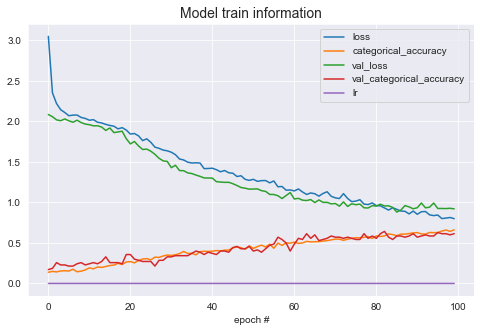

In [81]:
model_helper.plot_model_train_info(densenet_model_history)


In [82]:
densenet_info = model_helper.get_model_info(densenet_model_history, 'densenet')
densenet_info

densenet
loss_min                      0.799762
val_loss_min                  0.881518
categorical_accuracy_max      0.661972
val_categorical_accuracy_max  0.642857

In [101]:
densenet_model.evaluate(test_dataset)

7/7 [==============================] - 1s 53ms/step - loss: 0.7901 - categorical_accuracy: 0.6635


[0.7901179194450378, 0.6634615659713745]

In [183]:
densenet_metrics = get_metrics_for_model(model = densenet_model,model_name= 'densenet')
densenet_metrics

4/4 [==============================] - 0s 142ms/step
0.6971739999999045


densenet
recall     0.528846
precision  0.873016
auc        0.954043

In [110]:
# 
dump_model(densenet_model, 'G:/Learning/Degree Courses/MS AI ML/Research/Tea Sickeness Project/Code/output', 'densenet_model_with_aug')

### 5.3 ResNet-50

In [56]:
resnet = resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
resnet_model = ModelBuilder(pretrained_model_ref=resnet, num_classes=8)
# densenet_model.summary()


In [54]:
model_helper = ModelHelper(model=resnet_model, LR=0.0001)
resnet_model = model_helper.compile_model(optimizer_name='adam')
resnet_model.build(input_shape=INPUT_SHAPE_BUILD)
resnet_model.summary()


Model: "model_builder_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_max_pooling2d_3 (Glo  multiple                 0         
 balMaxPooling2D)                                                
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_connection_6 (DenseCo  multiple                 131136    
 nnection)                                                       
                                                                 
 dense_connection_with_dropo  multiple                 4160      
 ut_9 (DenseConnectionWithDr                                     
 opout)                                            

In [113]:
callbacks_lst = [model_helper.decrease_lr_on_plateau_callback()]
resnet_model_history = resnet_model.fit(train_dataset,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=100,
                                        verbose=1,
                                        callbacks=callbacks_lst,
                                        validation_data=val_datset,
                                        validation_steps=validation_steps,
                                        class_weight=None,
                                        workers=1,
                                        initial_epoch=0)


Epoch 1/100
71/71 [==============================] - 10s 87ms/step - loss: 2.3490 - categorical_accuracy: 0.1505 - val_loss: 2.0973 - val_categorical_accuracy: 0.0714 - lr: 1.0000e-04
Epoch 2/100
71/71 [==============================] - 5s 64ms/step - loss: 2.1286 - categorical_accuracy: 0.1558 - val_loss: 2.0566 - val_categorical_accuracy: 0.1857 - lr: 1.0000e-04
Epoch 3/100
71/71 [==============================] - 6s 70ms/step - loss: 2.0924 - categorical_accuracy: 0.1734 - val_loss: 2.0306 - val_categorical_accuracy: 0.1571 - lr: 1.0000e-04
Epoch 4/100
71/71 [==============================] - 5s 62ms/step - loss: 2.0082 - categorical_accuracy: 0.2060 - val_loss: 1.9271 - val_categorical_accuracy: 0.2143 - lr: 1.0000e-04
Epoch 5/100
71/71 [==============================] - 5s 57ms/step - loss: 2.0071 - categorical_accuracy: 0.2016 - val_loss: 1.9095 - val_categorical_accuracy: 0.3429 - lr: 1.0000e-04
Epoch 6/100
71/71 [==============================] - 5s 66ms/step - loss: 1.9347 - c

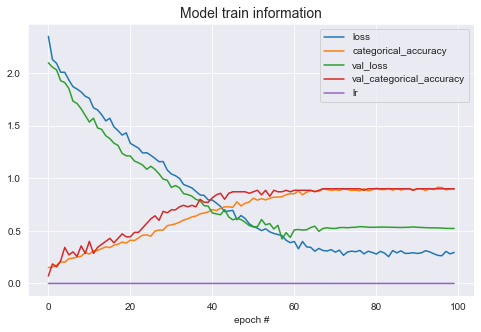

In [114]:
model_helper.plot_model_train_info(resnet_model_history)


In [116]:
resnet_info = model_helper.get_model_info(resnet_model_history, 'resnet')
resnet_info

resnet
loss_min                      0.254310
val_loss_min                  0.422478
categorical_accuracy_max      0.914613
val_categorical_accuracy_max  0.900000

In [118]:
resnet_model.evaluate(test_dataset)

7/7 [==============================] - 1s 68ms/step - loss: 0.6232 - categorical_accuracy: 0.8462


[0.6232089400291443, 0.8461538553237915]

In [185]:
resnet_metrics = get_metrics_for_model(model = resnet_model, model_name= 'resnet')
resnet_metrics

4/4 [==============================] - 0s 144ms/step
0.7682621000003564


resnet
recall     0.846154
precision  0.854369
auc        0.968228

In [171]:
# 
dump_model(resnet_model, 'G:/Learning/Degree Courses/MS AI ML/Research/Tea Sickeness Project/Code/output', 'resnet_model_with_aug')

### 5.3 Mobilenet

In [139]:
mobilenet = MobileNetV2(
    include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
mobilenet_model = ModelBuilder(pretrained_model_ref=mobilenet, num_classes=8)


In [140]:
model_helper = ModelHelper(model=mobilenet_model, LR=0.0001)
mobilenet_model = model_helper.compile_model(optimizer_name='adam')
mobilenet_model.build(input_shape=INPUT_SHAPE_BUILD)
mobilenet_model.summary()


Model: "model_builder_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d_8 (Glo  multiple                 0         
 balMaxPooling2D)                                                
                                                                 
 flatten_8 (Flatten)         multiple                  0         
                                                                 
 dense_connection_16 (DenseC  multiple                 81984     
 onnection)                                                      
                                                                 
 dense_connection_with_dropo  multiple                 4160      
 ut_24 (DenseConnectionWithD                       

In [141]:
callbacks_lst = [model_helper.decrease_lr_on_plateau_callback()]

mobilenet_model_history = mobilenet_model.fit(train_dataset,
                                              steps_per_epoch=steps_per_epoch,
                                              epochs=100,
                                              verbose=1,
                                              callbacks=callbacks_lst,
                                              validation_data=val_datset,
                                              validation_steps=validation_steps,
                                              class_weight=None,
                                              workers=1,
                                              initial_epoch=0)


Epoch 1/100
71/71 [==============================] - 7s 44ms/step - loss: 2.1963 - categorical_accuracy: 0.1303 - val_loss: 2.0561 - val_categorical_accuracy: 0.1571 - lr: 1.0000e-04
Epoch 2/100
71/71 [==============================] - 2s 25ms/step - loss: 2.0723 - categorical_accuracy: 0.1611 - val_loss: 2.0223 - val_categorical_accuracy: 0.1857 - lr: 1.0000e-04
Epoch 3/100
71/71 [==============================] - 2s 23ms/step - loss: 2.0478 - categorical_accuracy: 0.1602 - val_loss: 2.0177 - val_categorical_accuracy: 0.0714 - lr: 1.0000e-04
Epoch 4/100
71/71 [==============================] - 2s 22ms/step - loss: 2.0314 - categorical_accuracy: 0.1778 - val_loss: 1.9878 - val_categorical_accuracy: 0.1714 - lr: 1.0000e-04
Epoch 5/100
71/71 [==============================] - 2s 22ms/step - loss: 2.0066 - categorical_accuracy: 0.1919 - val_loss: 1.9664 - val_categorical_accuracy: 0.1286 - lr: 1.0000e-04
Epoch 6/100
71/71 [==============================] - 2s 22ms/step - loss: 1.9694 - ca

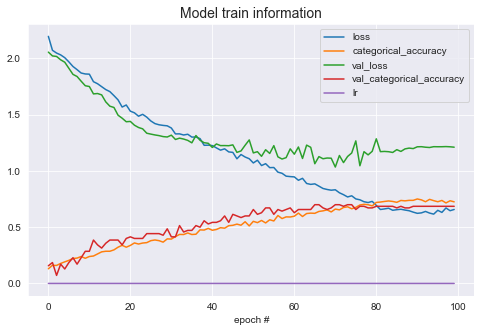

In [148]:
model_helper.plot_model_train_info(mobilenet_model_history)


In [149]:
mobilenet_info = model_helper.get_model_info(
    mobilenet_model_history, 'mobilenet')
mobilenet_info


mobilenet
loss_min                       0.616043
val_loss_min                   1.034571
categorical_accuracy_max       0.750880
val_categorical_accuracy_max   0.700000

In [150]:
mobilenet_model.evaluate(test_dataset)

7/7 [==============================] - 0s 22ms/step - loss: 1.0767 - categorical_accuracy: 0.6923


[1.0766693353652954, 0.692307710647583]

In [186]:
mobilenet_metrics = get_metrics_for_model(model = mobilenet_model, model_name= 'mobilenet')
mobilenet_metrics

4/4 [==============================] - 0s 75ms/step
0.5315497999999934


mobilenet
recall      0.625000
precision   0.738636
auc         0.925745

In [151]:
# 
dump_model(mobilenet_model, 'G:/Learning/Degree Courses/MS AI ML/Research/Tea Sickeness Project/Code/output', 'mobilenet_model_with_aug')

### 5.6 Comparing models trained on real + geometrically augmented data

In [190]:

all_model_info = pd.concat([densenet_info, resnet_info, mobilenet_info], axis=1)
all_model_metrics  = pd.concat([densenet_metrics, resnet_metrics, mobilenet_metrics], axis=1)
evaulation_info = pd.concat([all_model_info, all_model_metrics], axis=0)
evaulation_info


densenet    resnet  mobilenet
loss_min                      0.799762  0.254310   0.616043
val_loss_min                  0.881518  0.422478   1.034571
categorical_accuracy_max      0.661972  0.914613   0.750880
val_categorical_accuracy_max  0.642857  0.900000   0.700000
recall                        0.528846  0.846154   0.625000
precision                     0.873016  0.854369   0.738636
auc                           0.954043  0.968228   0.925745

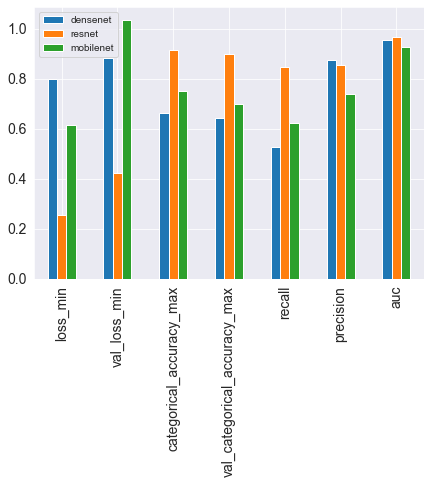

In [191]:
evaulation_info.plot.bar(figsize=[7, 5], grid=True, fontsize=14)
plt.show()


## 6 GANs

#### 6.1.1 Constants and hyperparameters for GAN

In [37]:
# global
num_channels = 3
num_classes = 8

# for conditional gan
latent_dim = 128

# for wgan & wgan-sn
noise_dim = 256

# Set the number of epochs for trainining.
wgan_epochs = 200

train_wgan = False
train_wgan_res = False


In [38]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)


136 11



#### 6.1.2 Save the model weights and outputs into zip file

In [39]:

def get_all_file_as_zip(model_history, gan_name='wgan', delete_prev=False):

    if delete_prev:
        if os.path.exists('./output'):
            shutil.rmtree('./output')

        if os.path.exists('./output.zip'):
            os.remove('./output.zip')

        if not os.path.exists('./output'):
            os.makedirs('./output')

    timestamp = (datetime.datetime.now() + datetime.timedelta(hours=5,
                 minutes=30)).strftime('%d_%m_%y_%H-%M-%S')
    pd.DataFrame(model_history.history).to_csv(
        f'./output/{gan_name}_history_{timestamp}.csv')

    shutil.move('./checkpoints', './output', )

    shutil.make_archive(f'output_{gan_name}_{timestamp}', 'zip', './output')

    os.chdir(r'/kaggle/working')
    FileLinks('./')


### 6.2 Streamlining the data loading for gan training

In [41]:
gan_train_img_path_lst, _ = get_train_test_fp_list(sickness_folder_processed_dict,
                                                   train_split_ratio=1.0,
                                                   test_split_ratio=0.0)

print(f'Train images # -> {len(gan_train_img_path_lst)}')


Train images # -> 885


### 6.3 Load the GAN training dataset

In [42]:
gan_train_data_df = get_img_path_and_labels_df(gan_train_img_path_lst)


gan_train_data_df.head()


paths     disease  anthracnose  \
0  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
1  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
2  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
3  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
4  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   

   algal leaf  bird eye spot  brown blight  gray light  healthy  \
0           1              0             0           0        0   
1           1              0             0           0        0   
2           1              0             0           0        0   
3           1              0             0           0        0   
4           1              0             0           0        0   

   red leaf spot  white spot  
0              0           0  
1              0           0  
2              0           0  
3              0           0  
4              0           0

In [43]:
gan_paths_X_train = gan_train_data_df['paths'].values.tolist()

[gan_paths_X_train[i] for i in np.random.randint(
    low=0, high=len(gan_paths_X_train)-1, size=5)]


['g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\white spot\\processed\\UNADJUSTEDNONRAW_thumb_ae.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\healthy\\processed\\UNADJUSTEDNONRAW_thumb_248.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\white spot\\processed\\UNADJUSTEDNONRAW_thumb_fe.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\brown blight\\processed\\UNADJUSTEDNONRAW_thumb_124.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\healthy\\processed\\UNADJUSTEDNONRAW_thumb_23c.jpg']

In [44]:
# .astype(np.float32)
gan_lables_y_train = gan_train_data_df[gan_train_data_df['disease'].unique(
)].values

[gan_lables_y_train[i] for i in np.random.randint(
    low=0, high=len(gan_lables_y_train)-1, size=5)]


[array([0, 0, 1, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8),
 array([0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8),
 array([1, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)]

In [45]:
gan_train_dataset = gen_dataset(
    gan_paths_X_train, gan_lables_y_train, batch_size=BATCH_SIZE_DATASET)


In [46]:
sample_gan_X_train_data, sample_gan_y_train_data = next(
    iter(gan_train_dataset))
sample_gan_X_train_data.shape, sample_gan_y_train_data.shape


(TensorShape([16, 180, 180, 3]), TensorShape([16, 8]))

### 6.5 Wasserstein GAN (WGAN) with Gradient Penalty (GP)


Info: https://arxiv.org/abs/1701.07875

#### 6.5.1 WGAN-Discriminator

In [72]:
def build_discriminator_wgan(discriminator_in_channels):
    discriminator = Sequential(
        [
            InputLayer(input_shape=(180, 180, discriminator_in_channels)),
            layers.ZeroPadding2D((2, 2)),
            Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2),
                   use_bias=True, activation=layers.LeakyReLU(0.2), padding='same'),
            Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2),
                   use_bias=True, activation=layers.LeakyReLU(0.2), padding='same'),
            layers.Dropout(0.3),
            Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2),
                   use_bias=True, activation=layers.LeakyReLU(0.2), padding='same'),
            layers.Dropout(0.3),
            Conv2D(filters=512, kernel_size=(5, 5), strides=(2, 2),
                   use_bias=True, activation=layers.LeakyReLU(0.2)),
            Flatten(),
            Dropout(0.2),
            Dense(1),


        ],
        name="discrinator_wgan"
    )

    return discriminator


In [73]:

d_model = build_discriminator_wgan(discriminator_in_channels)
d_model.summary()


Model: "discrinator_wgan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 184, 184, 11)     0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 92, 92, 64)        17664     
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 128)       204928    
                                                                 
 dropout_15 (Dropout)        (None, 46, 46, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 256)       819456    
                                                                 
 dropout_16 (Dropout)        (None, 23, 23, 256)       0         
                                                  

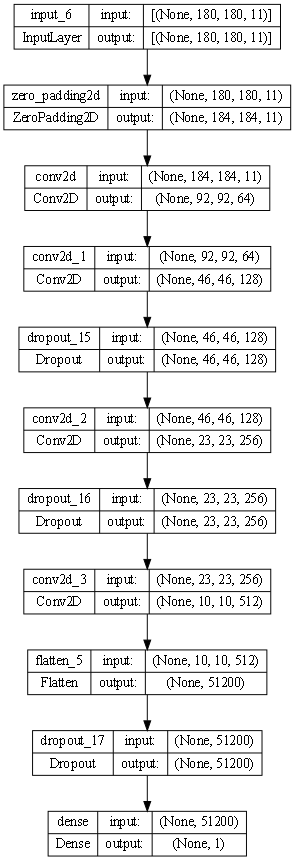

In [74]:
tf.keras.utils.plot_model(d_model, show_shapes=True,  to_file = 'd_model.png', dpi = 70)

#### 6.5.2 WGAN - Attention Network

In [75]:
def generate_mobilenet_feature_extrator(slice_layer_number=53, show_summary=False):
    mv = MobileNetV2(include_top=False, weights='imagenet',
                     input_shape=(180, 180, 3))
    for layers in mv.layers:
        layers.trainable = False
    _input = mv.input
    _output = mv.layers[slice_layer_number].output

    attn_model_feature_extractor = keras.Model(
        inputs=_input, outputs=_output, name='attn_model_feature_extractor')
    if show_summary:
        attn_model_feature_extractor.summary()

    return attn_model_feature_extractor


def conv_layers(kernels):
    return Conv2D(filters=kernels, kernel_size=(3, 3))


class AttentionModel(Model):
    """ Model to generate the context vector by using feature map and hidden state of decoder """

    def __init__(self, units):
        self.units = units
        super(AttentionModel, self).__init__()
        # Dense layer to take inputs of pretrained model

        self.pretrained_model = generate_mobilenet_feature_extrator(
            slice_layer_number=53)

        self.conv_layers_1 = conv_layers(self.units)
        self.bn_1 = keras.layers.BatchNormalization()

        self.conv_layers_2 = conv_layers(self.units)
        self.bn_2 = keras.layers.BatchNormalization()

        # self.flatten = Flatten(name='flatten')

        self.W1 = tf.keras.layers.Dense(self.units, name='1st_dense')

        # Dense layer to take loss input
        # self.W2 = tf.keras.layers.Dense(self.units)

        # Dense layer having one neuron to hold the score of a context vector
        self.V = tf.keras.layers.Dense(1, name='score')

        # self.aggregate_dense = tf.keras.layers.Dense(units)

    def call(self, imgs):

        features = self.pretrained_model(imgs)
        features = self.conv_layers_1(features)
        features = self.bn_1(features)

        features = self.conv_layers_2(features)
        features = self.bn_2(features)

        # build your score funciton to shape: (batch_size, 8*8, units)
        attention_hidden_layer = tf.keras.activations.tanh(self.W1(features))
        # self.W2(loss))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.keras.activations.softmax(score, axis=1)

        # shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        # context_vector = attention_weights * features
        context_vector = tf.matmul(
            attention_weights, features, transpose_a=True)

        # context_vector = self.aggregate_dense(context_vector)
        context_vector = tf.reshape(
            context_vector, [-1, context_vector.shape[1], context_vector.shape[3]])

        return context_vector

    def summary(self):
        x = keras.layers.Input(shape=(180, 180, 3))
        model = keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

    # def build(self, input_shape):
    #     x = keras.layers.Input(shape=input_shape)
    #     model = keras.Model(inputs=[x], outputs=self.call(x))
    #     model.build()


In [76]:
am = AttentionModel(32)
am.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 attn_model_feature_extractor (  (None, 23, 23, 32)  59008       ['input_8[0][0]']                
 Functional)                                                                                      
                                                                                                  
 conv2d_4 (Conv2D)              (None, 21, 21, 32)   9248        ['attn_model_feature_extractor[0]
                                                                 [0]']                        

#### 6.5.3 WGAN - Generator

In [77]:
def upsample_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), up_size=(2, 2), padding="same", use_bn=False, use_sn=False, use_bias=True, use_dropout=False, drop_value=0.3, name=''
                   ):

    x = layers.UpSampling2D(up_size, name=name + '-upsample')(x)

    # if spectral normalization is enabled
    if use_sn:
        conv2d_sn = tfa.layers.SpectralNormalization(layers.Conv2D(
            filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias, name=name+'-con2d'))
        x = conv2d_sn(x)
    else:
        x = layers.Conv2D(filters, kernel_size, strides=strides,
                          padding=padding, use_bias=use_bias, name=name+'-con2d')(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


In [78]:
def get_generator_model(add_residiual = False):
    noise = layers.Input(shape=(noise_dim,), name='noise')
    labels = layers.Input(shape=(num_classes,), name='lables')
    images = layers.Input(shape=(180, 180, 3), name='images')

    attention_vectors = AttentionModel(units=32)(images)

    if add_residiual:
        # Residual attention feed-fwd
        residual_atten_vectors = attention_vectors
        residual_atten_vectors = tf.keras.layers.Conv1D(filters= 60, kernel_size=3, activation='relu', name = 'residual_conv1')(residual_atten_vectors)
        residual_atten_vectors = tf.keras.layers.UpSampling1D()(residual_atten_vectors)
        residual_atten_vectors = tf.keras.layers.Conv1D(filters= 30, kernel_size=5, activation='relu', name = 'residual_conv2')(residual_atten_vectors)
        residual_atten_vectors = tf.keras.layers.BatchNormalization(name = 'residual_bn')(residual_atten_vectors)


    batch_size_train = tf.shape(images)[0]

    # shape = TensorShape([4, 8, 32])
    random_noise_vectors = tf.reshape(noise, shape=(batch_size_train, 8, 32))

    # shape = TensorShape([4, 19, 8]) -> random_noise_vectors x attention_vectors
    attention_vectors_with_noise = tf.matmul(random_noise_vectors, attention_vectors, transpose_b=True, name = 'noise_matmul_atten_vectors')

    # shape = TensorShape([4, 152])
    attention_vectors_with_noise = tf.reshape(attention_vectors_with_noise, shape=(batch_size_train, 152))

    # shape = TensorShape([4, 160])
    input_data = tf.concat([attention_vectors_with_noise, labels], axis=1)

    x = layers.Dense(15 * 15 * 256, use_bias=False)(input_data) # 57600
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    if add_residiual:
        # concatenating the residual_atten_vectors
        residual_atten_vectors = Flatten(name = 'residual_flatten')(residual_atten_vectors) # 900
        x = tf.concat([x,residual_atten_vectors ], axis = 1, name = 'concat_residual')



        x = layers.Reshape((15, 15, 260), name = 'residual_reshape')(x) # 58050

    else:
        x = layers.Reshape((15, 15, 256))(x) # 58050


    x = upsample_block(x, 128, layers.LeakyReLU(0.2), strides=(1, 1), up_size=(
        4, 4), use_bias=False, use_bn=True, padding="same", use_dropout=False, name='1')

    x = upsample_block(x, 64, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False,
                       use_bn=True, up_size=(3, 3), padding="same", use_dropout=False, name='2')

    x = upsample_block(x, 3, layers.Activation("tanh"), up_size=(
        1, 1), strides=(1, 1), use_bias=False, use_bn=True, name='3')

    g_model = keras.models.Model([noise, labels, images], x, name="generator")
    return g_model


In [79]:

g_model = get_generator_model(add_residiual=True)
g_model.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images (InputLayer)            [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (4,)                0           ['images[0][0]']                 
 )                                                                                                
                                                                                                  
 noise (InputLayer)             [(None, 256)]        0           []                               
                                                                                          

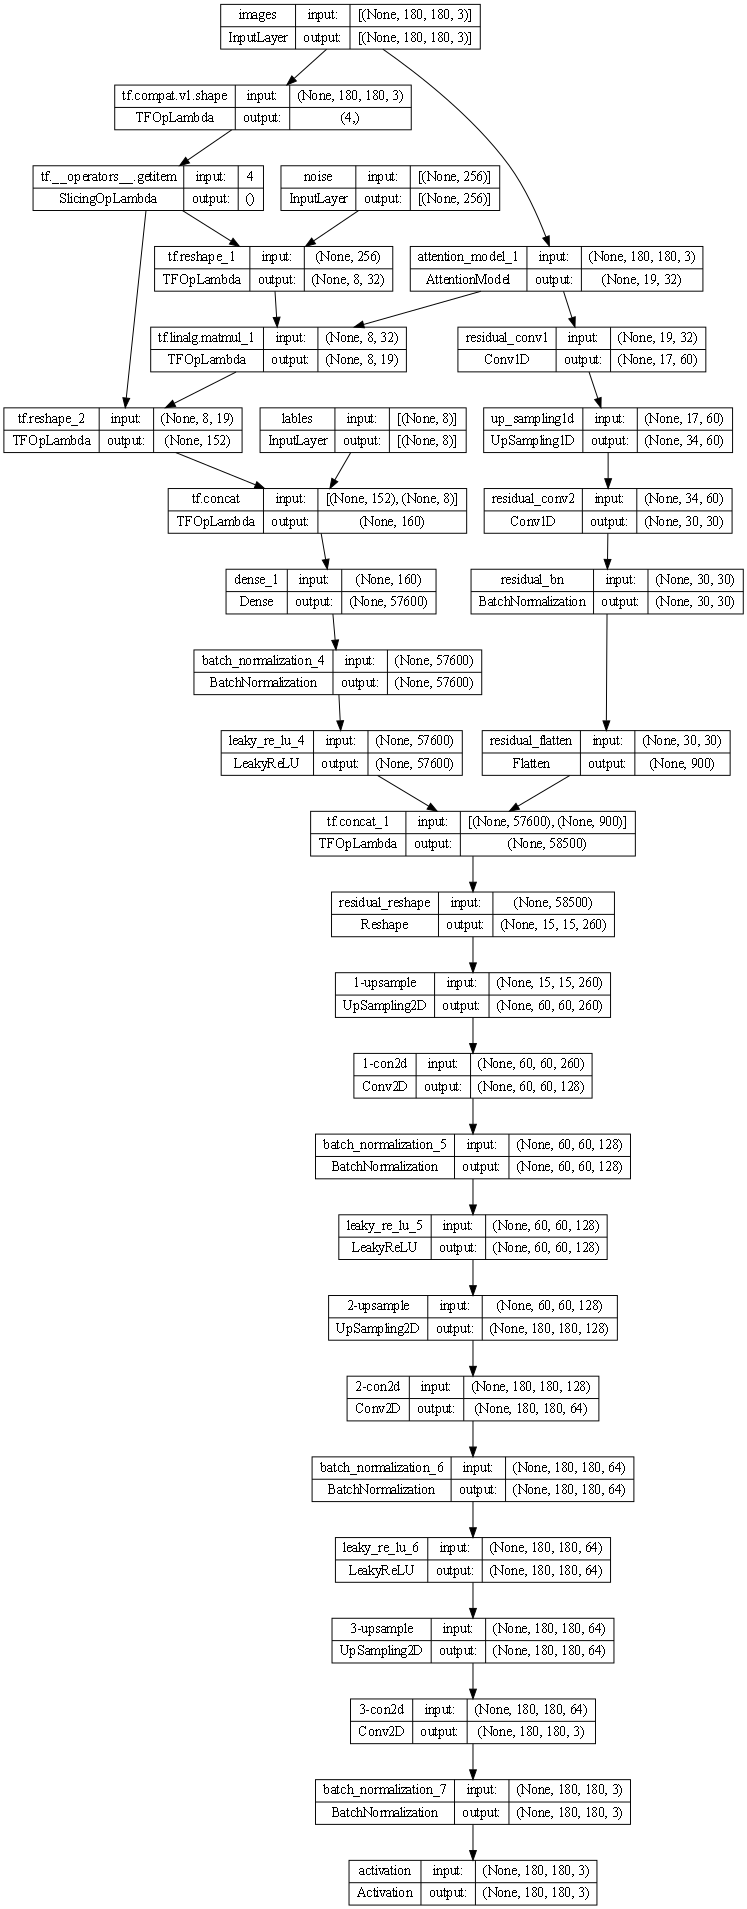

In [80]:
tf.keras.utils.plot_model(g_model, show_shapes=True,show_layer_names=True,  to_file = 'g_model.png', dpi = 70)

#### 6.5.4 Build WGAN model 

In [117]:
class WGAN(keras.Model):
    def __init__(self,discriminator,generator,latent_dim,discriminator_extra_steps=3,gp_weight=10.0,):

        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.attention_block = AttentionModel(units=32)
        self.preprocess_mobilenet = tf.keras.applications.mobilenet_v2.preprocess_input

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal(shape=[batch_size, 1, 1, 1], mean=0.0, stddev=1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data, image_size=IMG_SIZE_TRAIN[0], num_classes=8):

        # Unpack the data.
        real_images, one_hot_labels = data
        batch_size_train = tf.shape(real_images)[0]

        real_images = self.preprocess_mobilenet(real_images)

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(one_hot_labels, repeats=[image_size * image_size])

        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))

        ##################################
        ##### Discriminator Training #####
        ##################################

        for _ in range(self.d_steps):
            # shape = TensorShape([4, 256])
            random_latent_vectors = tf.random.normal(shape=(batch_size_train, self.latent_dim))

            # Train the discriminator.
            with tf.GradientTape() as tape:

                # Decode the noise (guided by labels) to fake images.
                # shape = (4, 180, 180, 3)
                generated_images_fake = self.generator([random_latent_vectors, one_hot_labels, real_images], training=True)

                # Combine them with real images. Note that we are concatenating the labels
                # with these images here.
                # shape = TensorShape([4, 180, 180, 11])
                fake_image_and_labels = tf.concat([generated_images_fake, image_one_hot_labels], -1)

                real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)

                predictions_on_fake = self.discriminator(fake_image_and_labels, training=True)
                predictions_on_real = self.discriminator(real_image_and_labels, training=True)

                d_loss_disc = self.d_loss_fn(real_data=predictions_on_real, pred_data=predictions_on_fake)
                #gp = self.gradient_penalty(batch_size, real_images, generated_images)
                gp = self.gradient_penalty(batch_size, real_image_and_labels, fake_image_and_labels)

                # Add the gradient penalty to the original discriminator loss
                d_loss = d_loss_disc + gp * self.gp_weight

            # Get gradients wrt disc loss
            d_grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

            # Update discriminator weights
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))

        ##############################
        ##### Generator Training #####
        ##############################

        # Sample random points in the latent space.
        # shape = TensorShape([4, 256])
        random_latent_vectors = tf.random.normal(shape=(batch_size_train, self.latent_dim))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:

            generated_images = self.generator([random_latent_vectors, one_hot_labels, real_images], training=True)

            fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)

            predictions = self.discriminator(fake_image_and_labels, training=True)

            g_loss = self.g_loss_fn(predictions)

        # Update the generator weights
        gen_grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))

        return {"g_loss": g_loss,"d_loss": d_loss}


#### 6.5.5 WGAN - Model save checkpoint

In [118]:
class SaveCheckpoint(keras.callbacks.Callback):
    def __init__(self, filepath, epoch_to_wait = 5):
        self._filepath = filepath 
        self._epoch_to_wait = epoch_to_wait

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self._epoch_to_wait == 0:
            timestamp = (datetime.datetime.now() + datetime.timedelta(hours = 5, minutes = 30)).strftime('%d_%m_%y_%H-%M-%S')
            folder_path = os.path.join(self._filepath, f'epoch_{epoch}_{timestamp}')
            os.makedirs(folder_path)
            self.model.save_weights(f'{folder_path}/wgan_ckp_epoch_{epoch}.h5') # saving in h5 format
            print(f'Cheeckpoint saved for eposh {epoch} at -> {folder_path}')
        



#### 6.5.6 WGAN - Image save callback

In [119]:
class ImageSaveCallback(keras.callbacks.Callback):
    def __init__(self, disease_lst, num_img, latent_dim, img_dump_dir):
        self.disease_lst = disease_lst
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.img_dump_dir = img_dump_dir
        self.gan_train_dataset = gen_dataset(gan_paths_X_train, gan_lables_y_train, batch_size=num_img)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch % 2 == 0):
            timestamp = (datetime.datetime.now() + datetime.timedelta(hours = 5, minutes = 30)).strftime('%d_%m_%y_%H-%M-%S')
            sample_gan_X_train_data, sample_gan_y_train_data = next(iter(self.gan_train_dataset))
            
            sample_gan_X_train_data = tf.keras.applications.mobilenet_v2.preprocess_input(sample_gan_X_train_data)
            
            batch_size_train = tf.shape(sample_gan_X_train_data)[0]


            random_latent_vectors = tf.random.normal(shape=(batch_size_train, self.latent_dim))

            generated_images = self.model.generator([random_latent_vectors, sample_gan_y_train_data, sample_gan_X_train_data])
            generated_images = (generated_images * 127.5) + 127.5

            for i, label in enumerate(sample_gan_y_train_data):
                idx = np.argmax(label)
                disease = self.disease_lst[idx]
                img = generated_images[i].numpy()
                img = keras.preprocessing.image.array_to_img(img)

                disease_path = f'{self.img_dump_dir}/{disease}'
                

                if not os.path.exists(disease_path):
                    os.makedirs(disease_path)

                img.save(f"{disease_path}/{disease}_{i}_{epoch}_{timestamp}.jpg")

#### 6.5.7 Training WGAN model

##### 6.5.7.1 Training - Without residual connection

In [120]:
# (learning_rate=0.0002, beta_1=0.5 are recommended)

# generator optimizers - lr = 0.0001, beta_1 = 0.5. beta_2 = 0.9
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

# discriminator optimizers - lr = 0.0004, beta_1 = 0.5. beta_2 = 0.9
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_data, pred_data):
    real_loss = tf.reduce_mean(real_data)
    
    fake_loss = tf.reduce_mean(pred_data)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


In [121]:
# Instantiate the custom `ImageSaveCallback` Keras callback.
cbk = ImageSaveCallback(num_img=BATCH_SIZE_GAN_TRAIN, latent_dim=noise_dim, disease_lst=train_data_df['disease'].unique().tolist(), img_dump_dir= './output/wgan')

# fid = FID()
# inception_score = IS()
checkpoint = SaveCheckpoint(filepath=MODEL_CHECKPOINT_PATHS['wgan'], epoch_to_wait=2)

# Get the wgan model
wgan = WGAN(discriminator=d_model, generator=g_model,latent_dim=noise_dim,discriminator_extra_steps=3)

In [122]:
if train_wgan:

# # Compile the wgan model
    wgan.compile(d_optimizer=discriminator_optimizer,
                g_optimizer=generator_optimizer,
                g_loss_fn=generator_loss,
                d_loss_fn=discriminator_loss)
                
    # Start training
    wgan_hist = wgan.fit(gan_train_dataset,batch_size=BATCH_SIZE_GAN_TRAIN,epochs=wgan_epochs,callbacks=[checkpoint,cbk])

In [123]:
if train_wgan:
    pd.DataFrame(wgan_hist.history).plot(grid = True)

In [124]:
if kaggle:
    get_all_file_as_zip(model_history= wgan_hist, gan_name = 'wgan')

##### 6.5.7.2 Training - With residual connection

In [125]:
g_model_with_residual= get_generator_model(add_residiual=True)
g_model_with_residual.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images (InputLayer)            [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.compat.v1.shape_1 (TFOpLamb  (4,)                0           ['images[0][0]']                 
 da)                                                                                              
                                                                                                  
 noise (InputLayer)             [(None, 256)]        0           []                               
                                                                                          

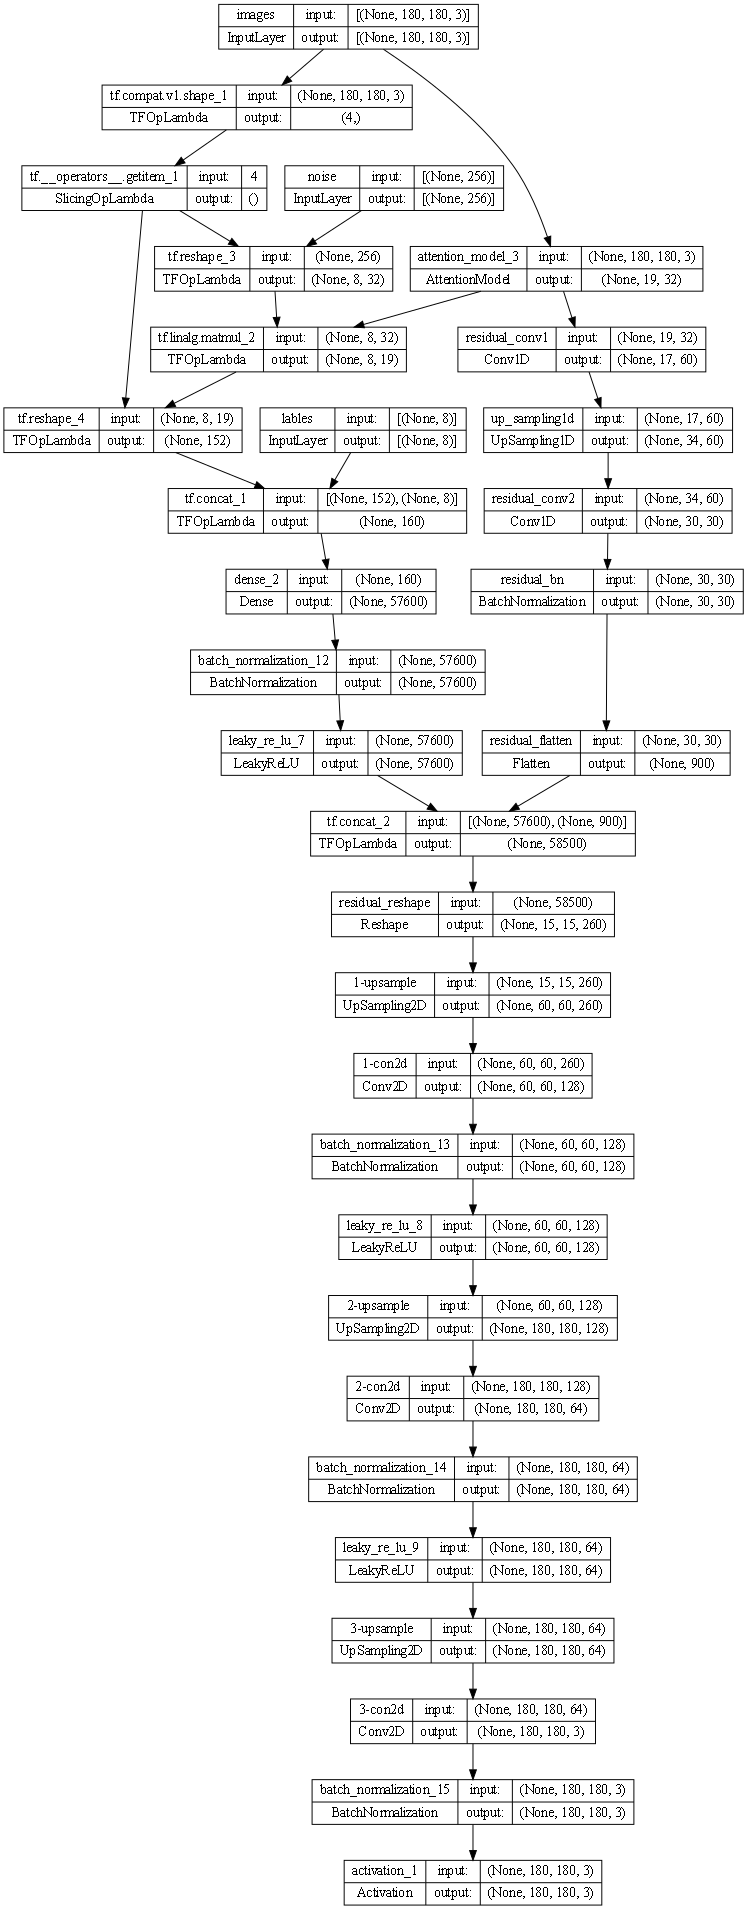

In [126]:
tf.keras.utils.plot_model(g_model_with_residual, show_shapes=True,show_layer_names=True,  to_file = 'g_model_with_residual.png', dpi = 70)

In [127]:
# Instantiate the custom `ImageSaveCallback` custom callback.
cbk = ImageSaveCallback(num_img=BATCH_SIZE_GAN_TRAIN,
                        latent_dim=noise_dim,
                        disease_lst=train_data_df['disease'].unique().tolist(),
                        img_dump_dir= './output/wgan_res')

# Instantiate the custom `SaveCheckpoint` custom callback.
checkpoint = SaveCheckpoint(filepath=MODEL_CHECKPOINT_PATHS['wgan_res'],
                            epoch_to_wait=2)

# Get the wgan model
wgan_res = WGAN(discriminator=d_model,
                generator=g_model_with_residual,
                latent_dim=noise_dim,
                discriminator_extra_steps=3)

In [128]:
if train_wgan_res:
    # # Compile the wgan model
    wgan_res.compile(d_optimizer=discriminator_optimizer,
                g_optimizer=generator_optimizer,
                g_loss_fn=generator_loss,
                d_loss_fn=discriminator_loss)
                
    # Start training
    wgan_res_hist = wgan_res.fit(gan_train_dataset,batch_size=BATCH_SIZE_GAN_TRAIN,epochs=wgan_epochs,callbacks=[checkpoint,cbk])

In [129]:
if train_wgan_res:
    pd.DataFrame(wgan_res_hist.history).plot(grid = True)

In [130]:
if kaggle:
    get_all_file_as_zip(model_history= wgan_res_hist, gan_name = 'wgan_res')

## 7 Generate images for each classes

*Generate 100 images for each class which will be used by the proportional ratio mixing mechanism to train a pretrained model following:*

    • real + synthetic images
    • real + geometrical augmented + synthetic images

### 7.1 Loading the data paths for sampling and shuffling

In [47]:
actual_data_df


paths     disease  \
0    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
1    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
2    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
3    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
4    g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
..                                                 ...         ...   
706  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
707  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
708  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
709  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
710  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   

     anthracnose  algal leaf  bird eye spot  brown blight  gray light  \
0              0           1              0             0           0   
1              0           1              0             0           0   
2              0           1              0             0           0   
3              0           1              0             0           0   
4              0           1              0             0           0   
..           ...         ...            ...           ...         ...   
706            0           0              0             0           0   
707            0           0              0             0           0   
708            0           0              0             0           0   
709            0           0              0             0           0   
710            0           0              0             0           0   

     healthy  red leaf spot  white spot  
0          0              0           0  
1          0              0           0  
2          0              0           0  
3          0              0           0  
4          0              0           0  
..       ...            ...         ...  
706        0              0           1  
707        0              0           1  
708        0              0           1  
709        0              0           1  
710        0              0           1  

[711 rows x 10 columns]

In [48]:
actual_data_df.disease.value_counts()


red leaf spot    115
white spot       114
algal leaf        91
brown blight      91
anthracnose       80
bird eye spot     80
gray light        80
healthy           60
Name: disease, dtype: int64

In [49]:

def get_synthetic_img_generation_paths(df, disease, sample_size=100):
    disease_df = df[df['disease'] == disease]
    disease_df_sample = disease_df.sample(
        n=sample_size, axis=0, replace=True, random_state=42)
    disease_df = pd.concat([disease_df, disease_df_sample], axis=0)
    return disease_df


In [50]:
sample_data_df = pd.DataFrame()
for disease in actual_data_df['disease'].unique():
    sample_data_df = pd.concat([sample_data_df, get_synthetic_img_generation_paths(
        actual_data_df, disease)], axis=0)


In [51]:
sample_data_df.disease.value_counts()#.plot.bar(color = 'y')


red leaf spot    215
white spot       214
algal leaf       191
brown blight     191
anthracnose      180
bird eye spot    180
gray light       180
healthy          160
Name: disease, dtype: int64

In [52]:
# shuffle the data

sample_data_df = sample_data_df.sample(frac=1)
sample_data_df


paths        disease  \
335  g:\Learning\Degree Courses\MS AI ML\Research\T...   brown blight   
449  g:\Learning\Degree Courses\MS AI ML\Research\T...        healthy   
36   g:\Learning\Degree Courses\MS AI ML\Research\T...     algal leaf   
17   g:\Learning\Degree Courses\MS AI ML\Research\T...     algal leaf   
434  g:\Learning\Degree Courses\MS AI ML\Research\T...        healthy   
..                                                 ...            ...   
135  g:\Learning\Degree Courses\MS AI ML\Research\T...    anthracnose   
160  g:\Learning\Degree Courses\MS AI ML\Research\T...    anthracnose   
297  g:\Learning\Degree Courses\MS AI ML\Research\T...   brown blight   
497  g:\Learning\Degree Courses\MS AI ML\Research\T...  red leaf spot   
376  g:\Learning\Degree Courses\MS AI ML\Research\T...     gray light   

     anthracnose  algal leaf  bird eye spot  brown blight  gray light  \
335            0           0              0             1           0   
449            0           0              0             0           0   
36             0           1              0             0           0   
17             0           1              0             0           0   
434            0           0              0             0           0   
..           ...         ...            ...           ...         ...   
135            1           0              0             0           0   
160            1           0              0             0           0   
297            0           0              0             1           0   
497            0           0              0             0           0   
376            0           0              0             0           1   

     healthy  red leaf spot  white spot  
335        0              0           0  
449        1              0           0  
36         0              0           0  
17         0              0           0  
434        1              0           0  
..       ...            ...         ...  
135        0              0           0  
160        0              0           0  
297        0              0           0  
497        0              1           0  
376        0              0           0  

[1511 rows x 10 columns]

In [53]:
paths_X_train_syn_gen = sample_data_df['paths'].values.tolist()
lables_y_train_syn_gen = sample_data_df[sample_data_df['disease'].unique(
)].values


In [54]:
paths_X_train_syn_gen[:5]


['g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\brown blight\\processed\\UNADJUSTEDNONRAW_thumb_15e.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\healthy\\processed\\UNADJUSTEDNONRAW_thumb_225.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\algal leaf\\processed\\UNADJUSTEDNONRAW_thumb_64.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\algal leaf\\processed\\UNADJUSTEDNONRAW_thumb_11.jpg',
 'g:\\Learning\\Degree Courses\\MS AI ML\\Research\\Tea Sickeness Project\\Dataset\\tea sickness dataset\\healthy\\processed\\UNADJUSTEDNONRAW_thumb_226.jpg']

### 7.2 Generate synthetic images

In [125]:
class SyntheticImageGenerator():
    def __init__(self, model_ref, checkpoint_path, data_dump_dir):
        self._model_ref = model_ref
        self._checkpoint_path = checkpoint_path
        self._data_dump_dir = data_dump_dir
        self._image_path_dict = {}

        if self._model_ref:
            self.load_model_weights()
            print(
                f'INFO: Model loaded from from checkpoint -> {self._checkpoint_path}')

    def load_model_weights(self):
        try:
            self._model_ref.built = True
            self._model_ref.load_weights(self._checkpoint_path)
        except:
            raise Exception(
                f'Model load error!!!\nCheckpoint path: {self._checkpoint_path}')

    def generate_images(self, _noise, _real_data, _labels,):

        _fake_data = self._model_ref.generator([_noise, _labels, _real_data])

        return _fake_data

    def map_func_for_generation(self, image_path, lables):
        """ This function will take the image_path & caption and return it's feature & respective caption. """

        img_tensor = skimage.io.imread(image_path)  # .decode('utf-8'))
        img_tensor = img_tensor.astype(np.float32)
        lables = lables.astype(np.float32)

        return img_tensor, lables

    def handle_image_generation_and_dump(self, img_path, label, disease_lst):
        img_name = os.path.basename(img_path)
        X, y = self.map_func_for_generation(image_path=img_path, lables=label)

        X = np.expand_dims(X, axis=0)
        y = y.reshape(1, -1)

        noise = tf.random.normal(shape=(1, 256))
        fake_data = self.generate_images(_noise=noise, _real_data=X, _labels=y)

        for i, data in enumerate(fake_data):
            idx = np.argmax(y[i])
            disease = disease_lst[idx]
            img_data = data.numpy()

            img_data = (img_data*127.5) + 127.5

            img_data = tf.keras.preprocessing.image.array_to_img(img_data)

            disease_path = f'{self._data_dump_dir}/{disease}/generated'

            if not os.path.exists(disease_path):
                os.makedirs(disease_path)

            img_path = f"{disease_path}/{img_name}"

            # logic for handling duplicate image samples
            if os.path.exists(img_path):
                _path, _format = os.path.splitext(img_path)

                _path = _path + '_'
                img_path = f'{_path}{_format}'

                if os.path.exists(img_path):
                    while os.path.exists(img_path):
                        _path = _path + '_'
                        img_path = f'{_path}{_format}'

            # if disease in self._image_path_dict:
            #     self._image_path_dict[disease].append(img_path)
            # else:
            #     self._image_path_dict[disease] = img_path


            img_data.save(img_path)

    def handle_synthetic_image_generation(self, disease_lst,paths_X_train_syn_gen, lables_y_train_syn_gen ):

        t1 = time.perf_counter()

        for img_path, label in tqdm(zip(paths_X_train_syn_gen, lables_y_train_syn_gen), desc='Generating synthetic images...'):

            self.handle_image_generation_and_dump(
                img_path=img_path, label=label, disease_lst=disease_lst)

        print(f'\nDumped images are in -> {self._data_dump_dir}')
        print(f'Elapsed time : {time.perf_counter() - t1}')



#### 7.2.1 Using wgan

In [ ]:
syn_img_gen = SyntheticImageGenerator(wgan,
                                     checkpoint_path= './checkpoints/vanilaa as h5 fromat/checkpoints/wgan/epoch_98_12_11_22_21-57-02/wgan_ckp_epoch_98.h5',
                                     data_dump_dir='./tmp/dump_vanilla')

In [ ]:
syn_img_gen.handle_synthetic_image_generation(disease_lst = sample_data_df['disease'].unique().tolist(),
                                              paths_X_train_syn_gen = paths_X_train_syn_gen,
                                              lables_y_train_syn_gen =lables_y_train_syn_gen )

#### 7.2.2 Using wgan with residual

In [144]:
syn_img_gen = SyntheticImageGenerator(wgan_res,
                                     checkpoint_path= './checkpoints/wgan_res/checkpoints/wgan/epoch_190_13_11_22_01-48-35/wgan_ckp_epoch_190.h5',
                                     data_dump_dir='./tmp/dump_residual')

INFO: Model loaded from from checkpoint -> ./checkpoints/wgan_res/checkpoints/wgan/epoch_190_13_11_22_01-48-35/wgan_ckp_epoch_190.h5


In [149]:
syn_img_gen.handle_synthetic_image_generation(disease_lst = sample_data_df['disease'].unique().tolist(),
                                              paths_X_train_syn_gen = paths_X_train_syn_gen,
                                              lables_y_train_syn_gen =lables_y_train_syn_gen )

Generating synthetic images...: 1511it [01:07, 22.41it/s]


Dumped images are in -> ./tmp/dump_residual
Elapsed time : 67.42022550000002


###  7.3 GAN Metrics 

In [55]:
import metrics_fid
import metrics_inception_score

Instructions for updating:
non-resource variables are not supported in the long term



In [56]:
def copy_real_images(real_img_path_list, dst_directory='./tmp/dump_real_image'):

    if len(list(os.walk(dst_directory))) > 0:
        print(f'Found old files in {dst_directory}, all deleted')
        shutil.rmtree(dst_directory)

    for src_path in tqdm(real_img_path_list, desc='Copying files...'):
        img_name = os.path.basename(src_path)
        disease_name = os.path.basename(list(pb.Path(src_path).parents)[1])

        _dst_directory = f'{dst_directory}/{disease_name}'

        if not os.path.exists(_dst_directory):
            os.makedirs(_dst_directory)

        dst_path = os.path.join(_dst_directory, img_name)

        if os.path.exists(dst_path):
            _path, _format = os.path.splitext(dst_path)

            _path = _path + '_'
            dst_path = f'{_path}{_format}'

            if os.path.exists(dst_path):
                while os.path.exists(dst_path):
                    _path = _path + '_'
                    dst_path = f'{_path}{_format}'

        shutil.copy(src=src_path, dst=dst_path)


In [57]:
copy_real_images(paths_X_train_syn_gen)

Found old files in ./tmp/dump_real_image, all deleted


Copying files...: 100%|██████████| 1511/1511 [00:01<00:00, 1444.07it/s]


In [58]:
def load_img_as_np_array(directory):
    
    t1 = time.perf_counter()
    path_lst = list(pb.Path(directory).rglob('*.jpg'))
    buffer_arr = np.zeros([len(path_lst), 180,180,3], dtype='uint8')
    for idx, path in enumerate(path_lst):
        img_tensor = skimage.io.imread(path)  # .decode('utf-8'))
        img_tensor = img_tensor.astype(np.float16)
        buffer_arr[idx,:,:,:] = img_tensor

    
    buffer_arr = buffer_arr.transpose([0,3,2,1]) # [n,h,w,c] -> [n,c,h,w]
    print(f'Shape -> {buffer_arr.shape}')
    print(time.perf_counter() - t1)
    return buffer_arr


In [59]:
# getting the synthetic data as np array of vanilla wgan
synthetic_dataset_vanilla  = load_img_as_np_array('./tmp/dump_vanilla')

# getting the synthetic data as np array of wgan residual
synthetic_dataset_residual  = load_img_as_np_array('./tmp/dump_residual')

# getting the real data as np array
real_dataset  = load_img_as_np_array('./tmp/dump_real_image') 

Shape -> (1511, 3, 180, 180)
7.320514500000002
Shape -> (1511, 3, 180, 180)
8.529941999999991
Shape -> (1511, 3, 180, 180)
6.605897900000002


##### 7.3.1 FID

Reference : https://github.com/tsc2017/Frechet-Inception-Distance

In [60]:
fid_score_vanilla = metrics_fid.get_fid(images1 = synthetic_dataset_vanilla, images2 = real_dataset)

Calculating FID with 1511 images from each distribution
FID calculation time: 40.583334 s
172.94228


In [61]:
fid_score_residual = metrics_fid.get_fid(images1 = synthetic_dataset_residual, images2 = real_dataset)

Calculating FID with 1511 images from each distribution
FID calculation time: 24.718984 s
281.71237


##### 7.3.2 Inception Score

Reference : https://github.com/tsc2017/Inception-Score

In [62]:
metrics_inception_score.get_inception_score(images=synthetic_dataset_vanilla)

Calculating Inception Score with 1511 images in 10 splits
Inception Score calculation time: 11.716706 s
2.0013933 0.06932645


(2.0013933, 0.06932645)

In [63]:
metrics_inception_score.get_inception_score(images=synthetic_dataset_residual)

Calculating Inception Score with 1511 images in 10 splits
Inception Score calculation time: 8.055150 s
2.5177855 0.089876


(2.5177855, 0.089876)

## 8 Load images for final classification model training

### 8.1 Generate the synthetic images in the train directory

In [141]:
syn_img_gen_final = SyntheticImageGenerator(wgan,
                                     checkpoint_path= './checkpoints/wgan/checkpoints/wgan/epoch_98_12_11_22_21-57-02/wgan_ckp_epoch_98.h5',
                                     data_dump_dir='../Dataset/tea sickness dataset')

INFO: Model loaded from from checkpoint -> ./checkpoints/wgan/checkpoints/wgan/epoch_98_12_11_22_21-57-02/wgan_ckp_epoch_98.h5


In [142]:
syn_img_gen_final.handle_synthetic_image_generation(disease_lst = sample_data_df['disease'].unique().tolist(),
                                                  paths_X_train_syn_gen = paths_X_train_syn_gen,
                                                  lables_y_train_syn_gen =lables_y_train_syn_gen )

Generating synthetic images...: 1511it [01:05, 23.18it/s]


Dumped images are in -> ../Dataset/tea sickness dataset
Elapsed time : 65.18648209999998


In [213]:
def get_synthetic_image_paths(directory, disease_list):
    image_path_list = []
    for disease in disease_list:
        image_path_list_disease = list(pb.Path(f'{directory}/{disease}/generated').glob('*.jpg'))
        image_path_list.extend(image_path_list_disease)
   
    return image_path_list

In [214]:
synthtic_images_lst = get_synthetic_image_paths('../Dataset/tea sickness dataset', actual_data_df['disease'].unique().tolist() )

### 8.2 Get a dataframe having the disease paths and respective OHE labels

In [215]:
synthetic_df  = get_img_path_and_labels_df(synthtic_images_lst)
synthetic_df

paths     disease  \
0     g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
1     g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
2     g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
3     g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
4     g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf   
...                                                 ...         ...   
1506  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
1507  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
1508  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
1509  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   
1510  g:\Learning\Degree Courses\MS AI ML\Research\T...  white spot   

      algal leaf  anthracnose  bird eye spot  brown blight  gray light  \
0              1            0              0             0           0   
1              1            0              0             0           0   
2              1            0              0             0           0   
3              1            0              0             0           0   
4              1            0              0             0           0   
...          ...          ...            ...           ...         ...   
1506           0            0              0             0           0   
1507           0            0              0             0           0   
1508           0            0              0             0           0   
1509           0            0              0             0           0   
1510           0            0              0             0           0   

      healthy  red leaf spot  white spot  
0           0              0           0  
1           0              0           0  
2           0              0           0  
3           0              0           0  
4           0              0           0  
...       ...            ...         ...  
1506        0              0           1  
1507        0              0           1  
1508        0              0           1  
1509        0              0           1  
1510        0              0           1  

[1511 rows x 10 columns]

In [216]:
def get_proportional_random_mixing(actual_data, synthetic_data, synthetic_percent = 20 ):
    
    print(f'Shape of actual data -> {actual_data.shape}\nShape of synthetic data -> {synthetic_data.shape}')
    synthetic_percent = synthetic_percent/100
    num_rows_synthetic = int(np.ceil(synthetic_data.shape[0]*synthetic_percent))
    print(f'Synthetic sample size -> {num_rows_synthetic}')
    
    df_synthtic_sample = synthetic_data.sample(n = num_rows_synthetic)
    
    merged_df =  pd.concat([actual_data, df_synthtic_sample], axis = 0)
    print(f'After merging shape of actual data -> {merged_df.shape}')
    return merged_df

## 9 Final classification model trainig

In [217]:

def get_proportional_mixed_data(merged_df):
    final_paths_X_train = merged_df['paths'].values.tolist()
    final_lables_y_train = merged_df[merged_df['disease'].unique()].values
    final_train_dataset = gen_dataset(final_paths_X_train, final_lables_y_train)
    return final_train_dataset, final_paths_X_train


In [218]:
def get_resnet():
    resnet = resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    resnet_model = ModelBuilder(pretrained_model_ref=resnet, num_classes=8)
    return resnet_model

In [219]:
INPUT_SHAPE = (180, 180, 3)
INPUT_SHAPE_BUILD = (None, 180, 180, 3)

### 9.1 Train model with real + 20% synthetic data

In [220]:
merged_df = get_proportional_random_mixing(actual_data_df, synthetic_df, synthetic_percent=20)
merged_df.head()

Shape of actual data -> (711, 10)
Shape of synthetic data -> (1511, 10)
Synthetic sample size -> 303
After merging shape of actual data -> (1014, 10)


paths     disease  anthracnose  \
0  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
1  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
2  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
3  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
4  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   

   algal leaf  bird eye spot  brown blight  gray light  healthy  \
0           1              0             0           0        0   
1           1              0             0           0        0   
2           1              0             0           0        0   
3           1              0             0           0        0   
4           1              0             0           0        0   

   red leaf spot  white spot  
0              0           0  
1              0           0  
2              0           0  
3              0           0  
4              0           0

In [221]:
resnet_model_final = get_resnet()
model_helper = ModelHelper(model=resnet_model_final, LR=0.0002)

resnet_model_with_syn_20 = model_helper.compile_model(optimizer_name='adam')
resnet_model_with_syn_20.build(input_shape=INPUT_SHAPE_BUILD)
resnet_model_with_syn_20.summary()

Model: "model_builder_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_max_pooling2d_9 (Glo  multiple                 0         
 balMaxPooling2D)                                                
                                                                 
 flatten_9 (Flatten)         multiple                  0         
                                                                 
 dense_connection_18 (DenseC  multiple                 131136    
 onnection)                                                      
                                                                 
 dense_connection_with_dropo  multiple                 4160      
 ut_27 (DenseConnectionWithD                                     
 ropout)                                           

In [222]:
train_dataset, paths_X_train = get_proportional_mixed_data(merged_df)

In [223]:
steps_per_epoch, validation_steps = get_epoch_settings(paths_X_train, paths_X_val, batch_size=BATCH_SIZE_TRAIN)
steps_per_epoch, validation_steps


data size is not factor of batch size(16), thus step/epoch = 64


(64, 5)

In [224]:

resnet_model_with_syn_20_history = resnet_model_with_syn_20.fit(train_dataset,
                                                                      steps_per_epoch=steps_per_epoch,
                                                                      epochs=100,
                                                                      verbose=1,
                                                                      callbacks=[model_helper.decrease_lr_on_plateau_callback()],
                                                                      validation_data=val_datset,
                                                                      validation_steps=validation_steps,
                                                                      class_weight=None,
                                                                      workers=1,
                                                                      initial_epoch=0)


Epoch 1/100
64/64 [==============================] - 9s 80ms/step - loss: 2.2581 - categorical_accuracy: 0.1519 - val_loss: 2.0500 - val_categorical_accuracy: 0.1857 - lr: 2.0000e-04
Epoch 2/100
64/64 [==============================] - 5s 64ms/step - loss: 2.0902 - categorical_accuracy: 0.1381 - val_loss: 2.0089 - val_categorical_accuracy: 0.2143 - lr: 2.0000e-04
Epoch 3/100
64/64 [==============================] - 5s 62ms/step - loss: 2.0274 - categorical_accuracy: 0.1617 - val_loss: 1.9114 - val_categorical_accuracy: 0.3429 - lr: 2.0000e-04
Epoch 4/100
64/64 [==============================] - 5s 63ms/step - loss: 1.9797 - categorical_accuracy: 0.2081 - val_loss: 1.8144 - val_categorical_accuracy: 0.2857 - lr: 2.0000e-04
Epoch 5/100
64/64 [==============================] - 5s 61ms/step - loss: 1.9263 - categorical_accuracy: 0.2288 - val_loss: 1.7039 - val_categorical_accuracy: 0.3571 - lr: 2.0000e-04
Epoch 6/100
64/64 [==============================] - 5s 63ms/step - loss: 1.8762 - ca

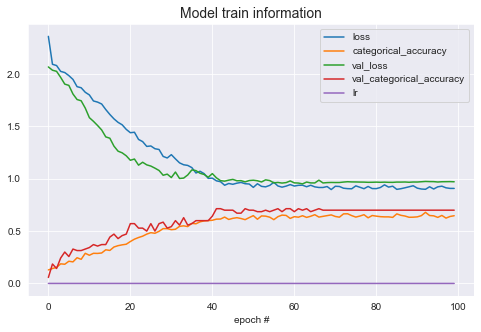

In [77]:
model_helper.plot_model_train_info(resnet_model_with_syn_20_history)

In [225]:
resnet_model_with_syn_20.evaluate(test_dataset)

7/7 [==============================] - 0s 51ms/step - loss: 0.5742 - categorical_accuracy: 0.8750


[0.5742290019989014, 0.875]

In [226]:
get_metrics_for_model(resnet_model_with_syn_20, 'resnet_model_with_syn_20')

4/4 [==============================] - 1s 80ms/step
1.1527188000000024


resnet_model_with_syn_20
recall                     0.865385
precision                  0.882353
auc                        0.979462

In [227]:
dump_model(resnet_model_with_syn_20, 'G:/Learning/Degree Courses/MS AI ML/Research/Tea Sickeness Project/Code/output', 'resnet_model_with_syn_20')

### 9.2 Train model with real + 40% synthetic data

In [228]:
merged_df = get_proportional_random_mixing(actual_data_df, synthetic_df, synthetic_percent=40)
merged_df.head()

Shape of actual data -> (711, 10)
Shape of synthetic data -> (1511, 10)
Synthetic sample size -> 605
After merging shape of actual data -> (1316, 10)


paths     disease  anthracnose  \
0  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
1  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
2  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
3  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
4  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   

   algal leaf  bird eye spot  brown blight  gray light  healthy  \
0           1              0             0           0        0   
1           1              0             0           0        0   
2           1              0             0           0        0   
3           1              0             0           0        0   
4           1              0             0           0        0   

   red leaf spot  white spot  
0              0           0  
1              0           0  
2              0           0  
3              0           0  
4              0           0

In [229]:
train_dataset, paths_X_train = get_proportional_mixed_data(merged_df)

In [230]:
steps_per_epoch, validation_steps = get_epoch_settings(paths_X_train, paths_X_val, batch_size=BATCH_SIZE_TRAIN)
steps_per_epoch, validation_steps


data size is not factor of batch size(16), thus step/epoch = 83


(83, 5)

In [231]:
resnet_model_final = get_resnet()
model_helper = ModelHelper(model=resnet_model_final, LR=0.0002)

resnet_model_with_syn_40 = model_helper.compile_model(optimizer_name='adam')
resnet_model_with_syn_40.build(input_shape=INPUT_SHAPE_BUILD)
resnet_model_with_syn_40.summary()

Model: "model_builder_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_max_pooling2d_10 (Gl  multiple                 0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_10 (Flatten)        multiple                  0         
                                                                 
 dense_connection_20 (DenseC  multiple                 131136    
 onnection)                                                      
                                                                 
 dense_connection_with_dropo  multiple                 4160      
 ut_30 (DenseConnectionWithD                                     
 ropout)                                          

In [232]:
resnet_model_with_syn_40_history = resnet_model_with_syn_40.fit(train_dataset,
                                                                      steps_per_epoch=steps_per_epoch,
                                                                      epochs=100,
                                                                      verbose=1,
                                                                      callbacks=[model_helper.decrease_lr_on_plateau_callback()],
                                                                      validation_data=val_datset,
                                                                      validation_steps=validation_steps,
                                                                      class_weight=None,
                                                                      workers=1,
                                                                      initial_epoch=0)


Epoch 1/100
83/83 [==============================] - 10s 73ms/step - loss: 2.4340 - categorical_accuracy: 0.1406 - val_loss: 2.0718 - val_categorical_accuracy: 0.1857 - lr: 2.0000e-04
Epoch 2/100
83/83 [==============================] - 5s 57ms/step - loss: 2.1245 - categorical_accuracy: 0.1543 - val_loss: 2.0241 - val_categorical_accuracy: 0.2571 - lr: 2.0000e-04
Epoch 3/100
83/83 [==============================] - 6s 58ms/step - loss: 2.0836 - categorical_accuracy: 0.1429 - val_loss: 1.9902 - val_categorical_accuracy: 0.2429 - lr: 2.0000e-04
Epoch 4/100
83/83 [==============================] - 5s 57ms/step - loss: 2.0673 - categorical_accuracy: 0.1641 - val_loss: 1.9446 - val_categorical_accuracy: 0.2143 - lr: 2.0000e-04
Epoch 5/100
83/83 [==============================] - 5s 57ms/step - loss: 2.0337 - categorical_accuracy: 0.1611 - val_loss: 1.9533 - val_categorical_accuracy: 0.2286 - lr: 2.0000e-04
Epoch 6/100
83/83 [==============================] - 5s 58ms/step - loss: 2.0273 - c

In [233]:
resnet_model_with_syn_40.evaluate(test_dataset)

7/7 [==============================] - 0s 50ms/step - loss: 0.7114 - categorical_accuracy: 0.8750


[0.7114195227622986, 0.875]

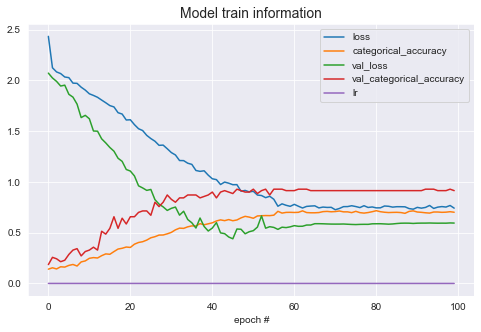

In [234]:
model_helper.plot_model_train_info(resnet_model_with_syn_40_history)

In [235]:
resnet_model_with_syn_40.evaluate(test_dataset)

7/7 [==============================] - 0s 47ms/step - loss: 0.7114 - categorical_accuracy: 0.8750


[0.7114185094833374, 0.875]

In [243]:
get_metrics_for_model(resnet_model_with_syn_40, 'resnet_model_with_syn_40')

4/4 [==============================] - 0s 81ms/step
0.46534500000052503


resnet_model_with_syn_40
recall                      0.87500
precision                   0.87500
auc                         0.95574

In [237]:
dump_model(resnet_model_with_syn_40, 'G:/Learning/Degree Courses/MS AI ML/Research/Tea Sickeness Project/Code/output', 'resnet_model_with_syn_40')

### 9.4 Train model with real + 100% synthetic data

In [238]:
merged_df = get_proportional_random_mixing(actual_data_df, synthetic_df, synthetic_percent=100)
merged_df.head()

Shape of actual data -> (711, 10)
Shape of synthetic data -> (1511, 10)
Synthetic sample size -> 1511
After merging shape of actual data -> (2222, 10)


paths     disease  anthracnose  \
0  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
1  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
2  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
3  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   
4  g:\Learning\Degree Courses\MS AI ML\Research\T...  algal leaf            0   

   algal leaf  bird eye spot  brown blight  gray light  healthy  \
0           1              0             0           0        0   
1           1              0             0           0        0   
2           1              0             0           0        0   
3           1              0             0           0        0   
4           1              0             0           0        0   

   red leaf spot  white spot  
0              0           0  
1              0           0  
2              0           0  
3              0           0  
4              0           0

In [239]:
resnet_model_final = get_resnet()
model_helper = ModelHelper(model=resnet_model_final, LR=0.0002)

resnet_model_with_syn_100 = model_helper.compile_model(optimizer_name='adam')
resnet_model_with_syn_100.build(input_shape=INPUT_SHAPE_BUILD)
resnet_model_with_syn_100.summary()

Model: "model_builder_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_max_pooling2d_11 (Gl  multiple                 0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_11 (Flatten)        multiple                  0         
                                                                 
 dense_connection_22 (DenseC  multiple                 131136    
 onnection)                                                      
                                                                 
 dense_connection_with_dropo  multiple                 4160      
 ut_33 (DenseConnectionWithD                                     
 ropout)                                          

In [240]:
train_dataset, paths_X_train = get_proportional_mixed_data(merged_df)

In [241]:
steps_per_epoch, validation_steps = get_epoch_settings(paths_X_train, paths_X_val, batch_size=BATCH_SIZE_TRAIN)
steps_per_epoch, validation_steps


data size is not factor of batch size(16), thus step/epoch = 139


(139, 5)

In [242]:
resnet_model_with_syn_100_history = resnet_model_with_syn_100.fit(train_dataset,
                                                                      steps_per_epoch=steps_per_epoch,
                                                                      epochs=100,
                                                                      verbose=1,
                                                                      callbacks=[model_helper.decrease_lr_on_plateau_callback()],
                                                                      validation_data=val_datset,
                                                                      validation_steps=validation_steps,
                                                                      class_weight=None,
                                                                      workers=1,
                                                                      initial_epoch=0)


Epoch 1/100
139/139 [==============================] - 13s 64ms/step - loss: 2.2282 - categorical_accuracy: 0.1283 - val_loss: 2.0493 - val_categorical_accuracy: 0.1571 - lr: 2.0000e-04
Epoch 2/100
139/139 [==============================] - 9s 57ms/step - loss: 2.0752 - categorical_accuracy: 0.1548 - val_loss: 1.9739 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/100
139/139 [==============================] - 9s 58ms/step - loss: 2.0663 - categorical_accuracy: 0.1566 - val_loss: 1.9893 - val_categorical_accuracy: 0.1571 - lr: 2.0000e-04
Epoch 4/100
139/139 [==============================] - 9s 58ms/step - loss: 2.0512 - categorical_accuracy: 0.1598 - val_loss: 1.9076 - val_categorical_accuracy: 0.1429 - lr: 2.0000e-04
Epoch 5/100
139/139 [==============================] - 9s 57ms/step - loss: 2.0303 - categorical_accuracy: 0.1467 - val_loss: 1.8498 - val_categorical_accuracy: 0.2571 - lr: 2.0000e-04
Epoch 6/100
139/139 [==============================] - 9s 58ms/step - loss

In [244]:
resnet_model_with_syn_100.evaluate(test_dataset)

7/7 [==============================] - 1s 60ms/step - loss: 0.8119 - categorical_accuracy: 0.7788


[0.8119307160377502, 0.7788461446762085]

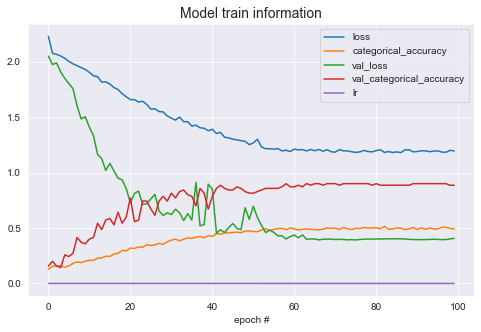

In [245]:
model_helper.plot_model_train_info(resnet_model_with_syn_100_history)

In [246]:
get_metrics_for_model(resnet_model_with_syn_100, 'resnet_model_with_syn_100')

4/4 [==============================] - 1s 142ms/step
1.3526507999995374


resnet_model_with_syn_100
recall                      0.778846
precision                   0.778846
auc                         0.961116

In [247]:
dump_model(resnet_model_with_syn_100, 'G:/Learning/Degree Courses/MS AI ML/Research/Tea Sickeness Project/Code/output', 'resnet_model_with_syn_100')